### Evaluate performance of saved model on test data

In [1]:
from collections import deque
from hmmlearn import hmm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
from tqdm import tqdm


from itertools import cycle
from sklearn.preprocessing import LabelBinarizer

from src.models import *
from src.dl_model_utils import Cholec80Dataset, get_transform_test
from src.eval_utils import *

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix,roc_auc_score,roc_curve,auc)

In [2]:
CLASS_LABELS = [
    "Preparation",
    "Calot Triangle Dissection",
    "Clipping and Cutting",
    "Gallbladder Dissection",
    "Gallbladder Packaging",
    "Cleaning and Coagulation",
    "Gallbladder Retraction",
]

INSTRUMENT_MAP = {
    '':0,
    'tool_Grasper':1,
    'tool_Grasper, tool_Hook':2,
    'tool_Hook':3,
    'tool_Grasper, tool_Irrigator':4,
    'tool_Irrigator':5,
    'tool_Bipolar':6,
    'tool_Grasper, tool_Bipolar':7,
    'tool_Grasper, tool_Clipper':8,
    'tool_Clipper':9,
    'tool_Grasper, tool_Scissors':10,
    'tool_SpecimenBag':11,
    'tool_Grasper, tool_SpecimenBag':12,
    'tool_Scissors':13,
    'tool_Grasper, tool_Bipolar, tool_Irrigator':14,
    'tool_Bipolar, tool_Irrigator':15,
    'tool_Bipolar, tool_SpecimenBag':16,
    'tool_Grasper, tool_Bipolar, tool_SpecimenBag':17,
    'tool_Irrigator, tool_SpecimenBag':18,
    'tool_Bipolar, tool_Irrigator, tool_SpecimenBag':19,
    'tool_Grasper, tool_Irrigator, tool_SpecimenBag':20,
    'tool_Grasper, tool_Clipper, tool_Irrigator':21,
    'tool_Clipper, tool_Irrigator':22,
    'tool_Grasper, tool_Clipper, tool_SpecimenBag':23,
    'tool_Grasper, tool_Scissors, tool_SpecimenBag':24,
    'tool_Hook, tool_Irrigator':25,
    'tool_Grasper, tool_Hook, tool_Irrigator':26,
    'tool_Bipolar, tool_Scissors':27
    }

MODEL_NUM = 11

In [3]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device Type : {}".format(device))

#Select model for evaluation and import
model, hmm_emission_df = model_select(model_num=MODEL_NUM)
model.to(device)
print('Model Loaded..')

Device Type : cuda
Model Loaded..


In [4]:
#Dataframe import for hmm emission data and test data for eval
test_df = pd.read_parquet('data/ordered_test_df.parquet')
# test_df = pd.read_parquet('data/ord_test_df.parquet')

test_df = test_df[test_df['frame'] % 25 == 0].reset_index(drop=True)

# hmm_train_df = pd.read_parquet('data/ordered_train_df.parquet')
# hmm_train_df = pd.read_parquet('data/ord_train_df.parquet')
train_df = pd.read_parquet('data/ordered_train_df.parquet')
val_df = pd.read_parquet('data/ordered_val_df.parquet')
# train_df = pd.read_parquet('data/ord_train_df.parquet')
# val_df = pd.read_parquet('data/ord_val_df.parquet')


#Sample train and val datasets at 1fps
train_df = train_df[train_df['frame'] % 25 == 0].reset_index(drop=True)
val_df = val_df[val_df['frame'] % 25 == 0].reset_index(drop=True)


test_df['tool_target'] = test_df[['tool_Grasper', 'tool_Bipolar',
        'tool_Hook', 'tool_Scissors', 'tool_Clipper', 'tool_Irrigator',
        'tool_SpecimenBag']].dot(test_df[['tool_Grasper', 'tool_Bipolar',
        'tool_Hook', 'tool_Scissors', 'tool_Clipper', 'tool_Irrigator',
        'tool_SpecimenBag']].columns + ', ').str.rstrip(', ').map(INSTRUMENT_MAP).values

In [5]:
hmm_train_df = pd.concat([train_df,val_df])


### Initialize HMM 

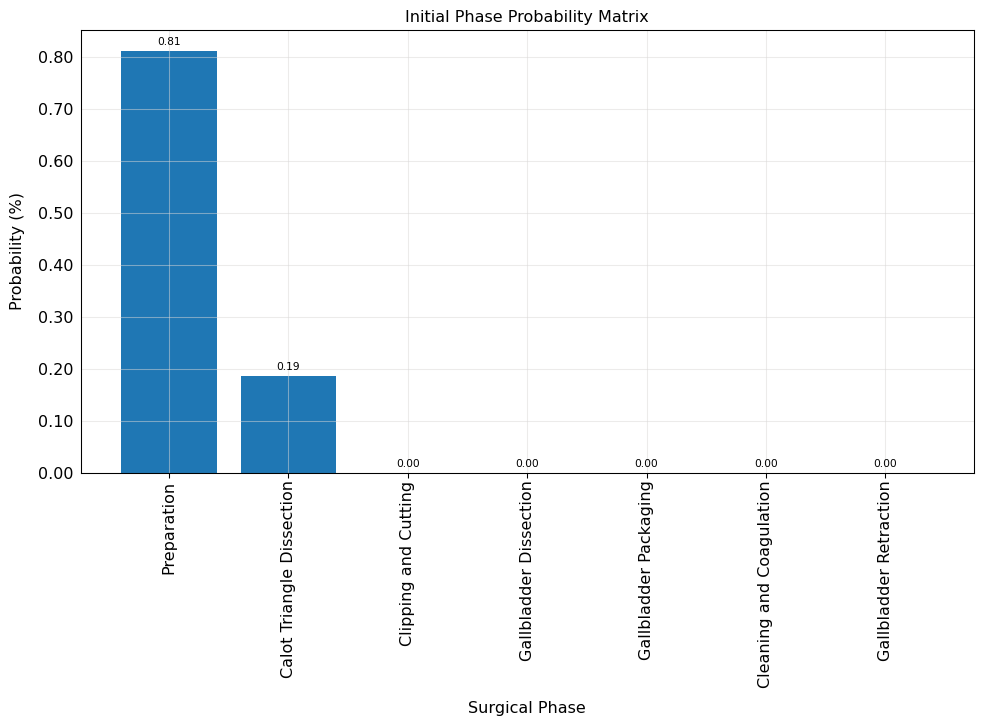

In [6]:
#Return initial hmm probabilities 
pi = get_initial_prob(hmm_train_df)

# Visualise initial probabilities
fig, ax = plt.subplots(figsize=(12,6), dpi = 96)
bar1 = ax.bar(x= CLASS_LABELS, height=pi)

plt.xlabel("")
plt.title("Initial Phase Probability Matrix")


# Create the grid 
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

# Reformat x-axis label and tick labels
ax.set_xlabel('Surgical Phase', fontsize=12, labelpad=10) # No need for an axis label
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_major_formatter(lambda s, i : f'{s:,.0f}')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)
plt.xticks(range(len(CLASS_LABELS)), CLASS_LABELS, rotation=90)

# Reformat y-axis
ax.set_ylabel('Probability (%)', fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_major_formatter(lambda s, i : f'{s:,.2f}')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

# Add label on top of each bar
ax.bar_label(bar1, labels=[f'{e:,.2f}' for e in pi], padding=3, color='black', fontsize=8)

plt.show()

In [7]:
full_transition_videos = hmm_train_df['video_num'].unique()[hmm_train_df.groupby('video_num')['phase'].nunique().values == 7]
full_hm_train_df = hmm_train_df[hmm_train_df['video_num'].isin(full_transition_videos)]


transmtrx_list = []
for video in full_hm_train_df['video_num'].unique():

    transmtrx = get_transition_matrix(full_hm_train_df[full_hm_train_df['video_num'] == video]['phase'].values,7)
    transmtrx_list.append(transmtrx)

transmtrx_final = np.divide(np.sum(transmtrx_list, axis=0), full_hm_train_df['video_num'].unique().shape[0])

C:\Users\vkula\AppData\Local\Temp\ipykernel_22144\1818194761.py:2: RuntimeWarning: divide by zero encountered in log
  corr = np.log(transmtrx_final)


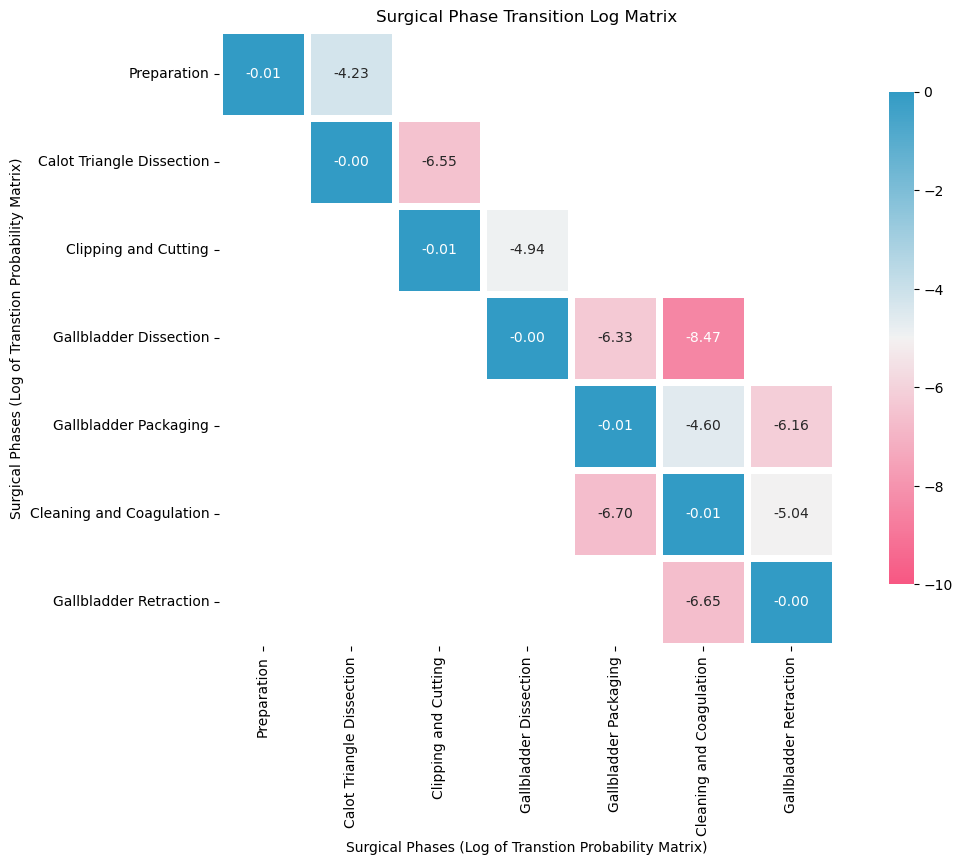

In [8]:
fig, ax = plt.subplots(figsize=(14, 8))# mask
corr = np.log(transmtrx_final)

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)# plot heatmap

sns.heatmap(corr, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-10, vmax=0, 
           cbar_kws={"shrink": .8},xticklabels=CLASS_LABELS,yticklabels=CLASS_LABELS, square=True)# ticks

# plt.xticks(range(len(CLASS_LABELS)), CLASS_LABELS, rotation=90)
# plt.yticks(range(len(CLASS_LABELS)), CLASS_LABELS,rotation=0,va='top',rotation_mode='anchor')
plt.title("Surgical Phase Transition Log Matrix")
plt.xlabel('Surgical Phases (Log of Transtion Probability Matrix)')
plt.ylabel('Surgical Phases (Log of Transtion Probability Matrix)')
plt.show()

C:\Users\vkula\AppData\Local\Temp\ipykernel_22144\1024416198.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(transmtrx_final), interpolation='nearest')


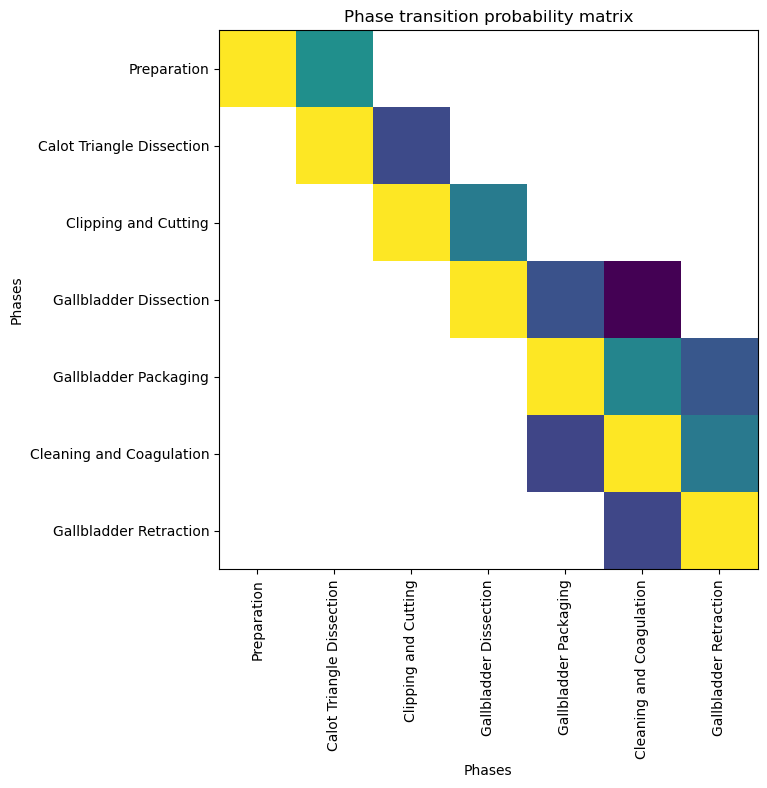

In [9]:
plt.figure(figsize=(7, 7))
from matplotlib.colors import LogNorm

plt.imshow(np.log(transmtrx_final), interpolation='nearest')
# sns.heatmap(np.log(transmtrx_final), cmap='RdYlGn', square=True,norm=LogNorm(), annot=True)


plt.xticks(range(len(CLASS_LABELS)), CLASS_LABELS, rotation=90)
plt.yticks(range(len(CLASS_LABELS)), CLASS_LABELS)
plt.xlabel("Phases")
plt.ylabel("Phases")
plt.title("Phase transition probability matrix")
plt.show()

In [10]:
# Create dataFrame for emission probabilities
train_pred_seq_df = hmm_emission_df[["img_path", "true_labels", "cnn_output"]]

In [11]:
probas_by_phases = [[], [], [], [], [], [], []]

# Computing emission statistics
for vidId, group in train_pred_seq_df.groupby("img_path"):
    probas = np.array(group["cnn_output"].tolist())
    classes = group["true_labels"].tolist()
    for i in range(len(probas)):
        probas_by_phases[classes[i]].append(probas[i])

In [12]:
# Compute sigmas & mus for 7 phases
mus = np.zeros((7,7))
sigmas = np.zeros((7,7,7))

for i in range(7):
    X = np.array(probas_by_phases[i])
    mus[i, :] = np.mean(X, axis=0)
    sigmas[i, :, :] = np.cov(X, rowvar=False)

In [13]:
# Initialise HMM
hmm_model = hmm.GaussianHMM(n_components=7, covariance_type="diag", verbose=True)
hmm_model.startprob_ = pi
hmm_model.transmat_ = transmtrx_final
hmm_model.means_ = mus
hmm_model.covars_ = np.array([np.diag(i) for i in sigmas])

### Vision Inference

In [14]:
#Create test loader
testset = Cholec80Dataset(test_df,  get_transform_test())
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False
)

# Get network prediction accuracy on the test images
grouth_truth_classes = []
predicted_classes = []
total = 0
correct = 0

#Outputs for HMM
img_path_test_list = []
soft_max_out_test = []
model.eval()
for data in tqdm(testloader):
    inputs, img_id, labels, tools  = data



    inputs = inputs.to(device)
    tools = tools.to(device)

    if MODEL_NUM != 12:
        test_outputs_phase = model(inputs)
    else:
        test_outputs_phase,_ = model(inputs)
    _, test_preds_phase = torch.max(test_outputs_phase.data.cpu(), 1)


    img_path_test_list = img_path_test_list + (list(img_id))
    grouth_truth_classes = grouth_truth_classes + labels.tolist()
    soft_max_out_test = soft_max_out_test + test_outputs_phase.tolist()
    predicted_classes = predicted_classes + test_preds_phase.tolist()


    total += labels.size(0)
    correct += (test_preds_phase == labels).sum().item()
        

results_df = pd.DataFrame(
    {'img_path': img_path_test_list,
        'true_labels': grouth_truth_classes,
        'cnn_output': soft_max_out_test,
        'predicted_labels': predicted_classes
    })
results_df['video_num'] = test_df['video_num']

#Save model inference
results_df.to_parquet(f'results/model_{MODEL_NUM}_results_32_df.parquet')

100%|██████████| 384/384 [07:41<00:00,  1.20s/it]


In [14]:
try: results_df
except : results_df = pd.read_parquet(f'results/model_{MODEL_NUM}_results_df.parquet',engine='fastparquet')

Start decoding vid video49:  ...


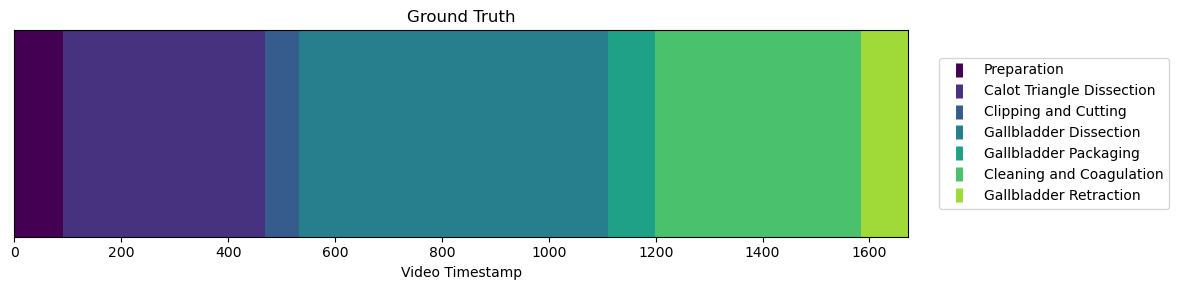

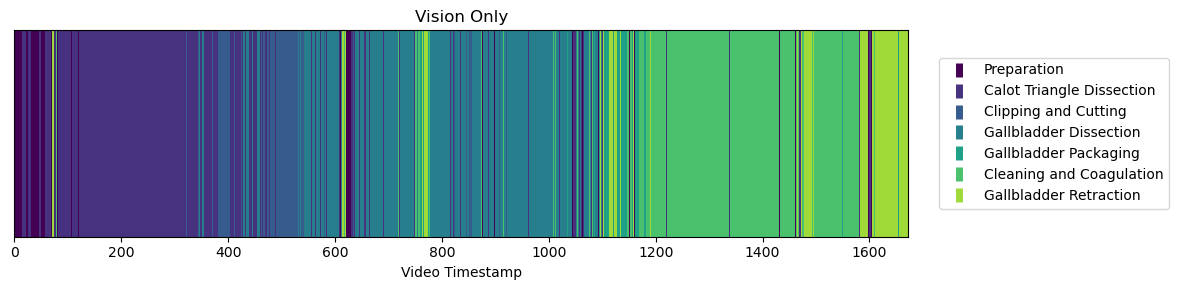

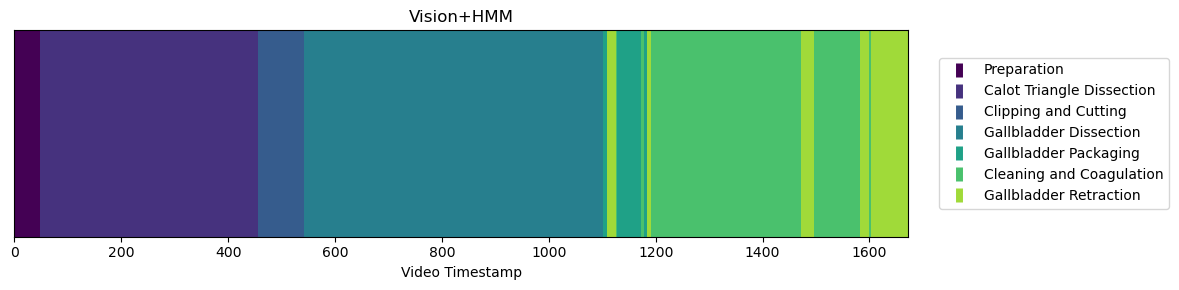

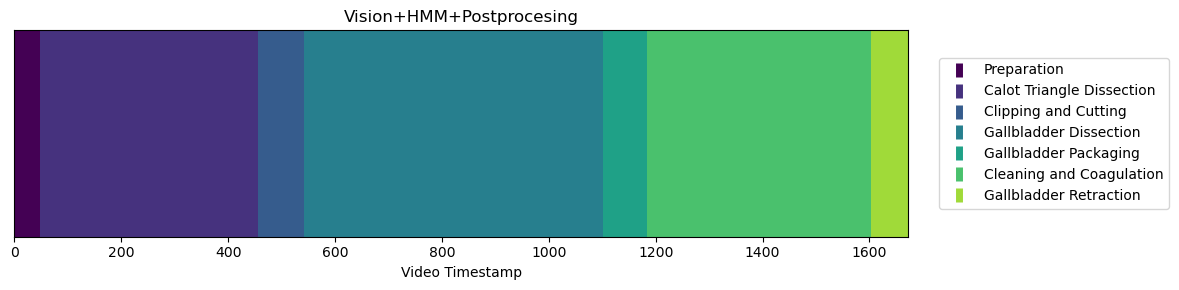

Start decoding vid video50:  ...


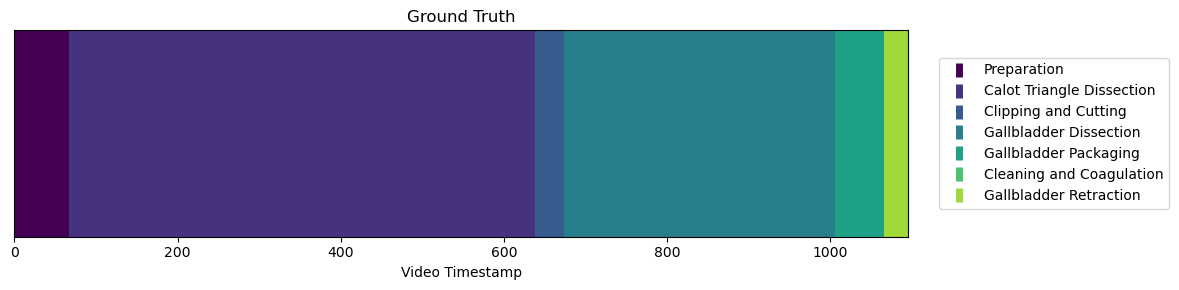

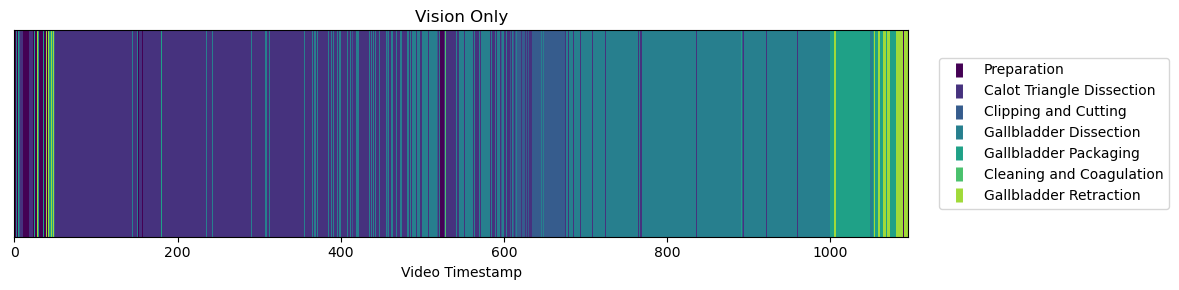

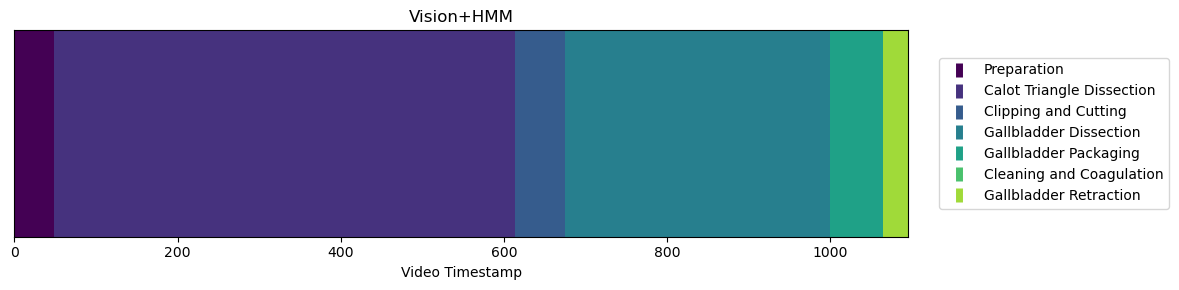

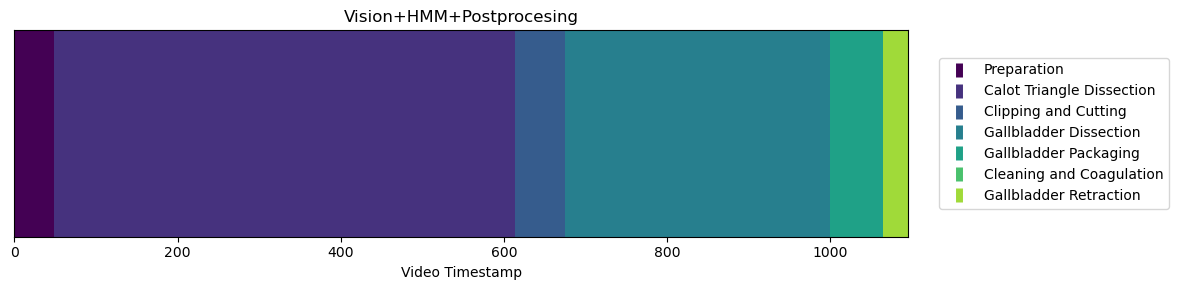

Start decoding vid video51:  ...


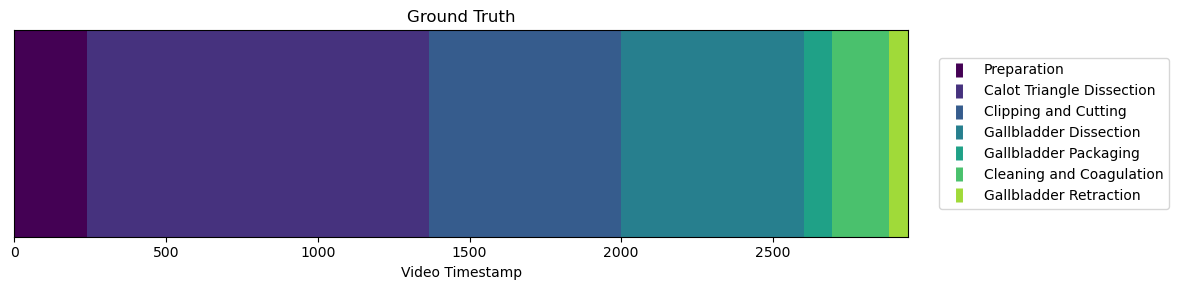

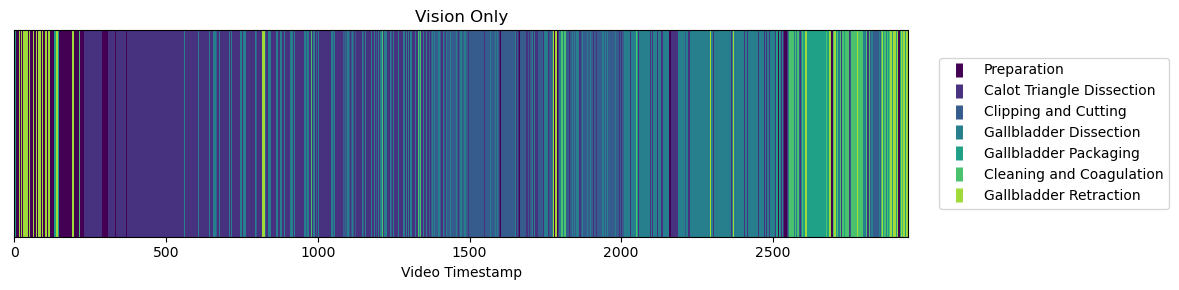

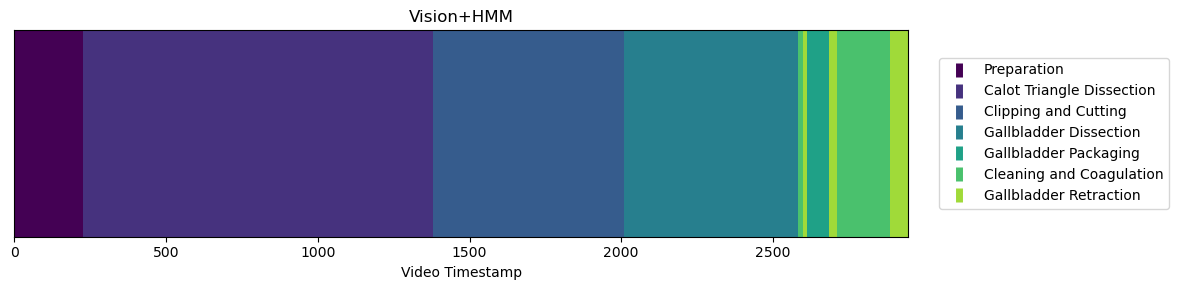

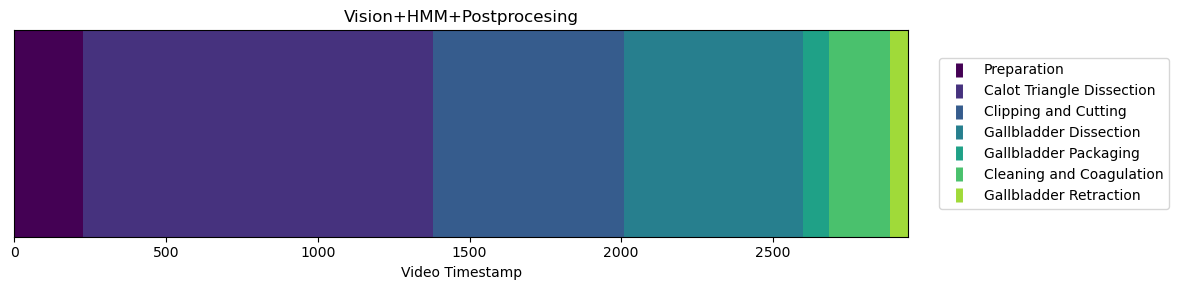

Start decoding vid video52:  ...


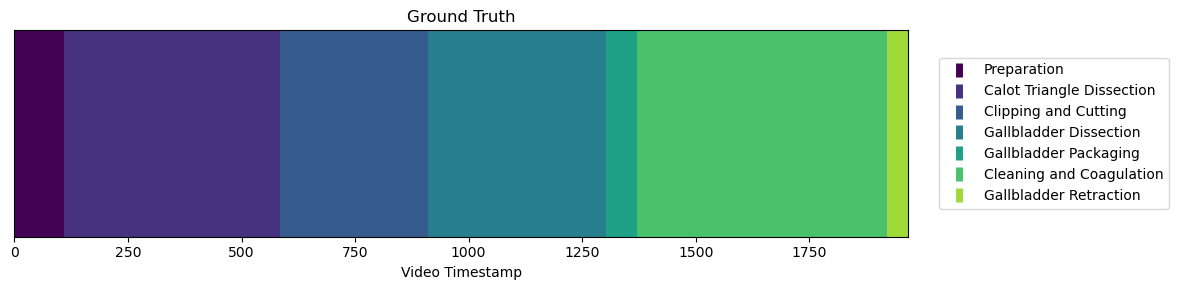

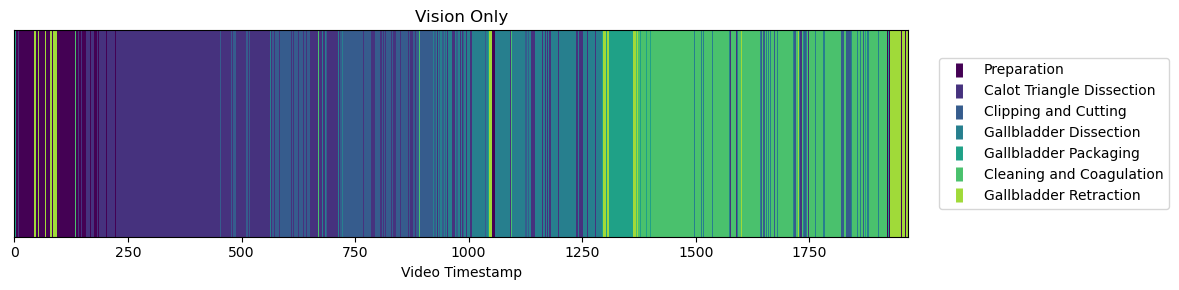

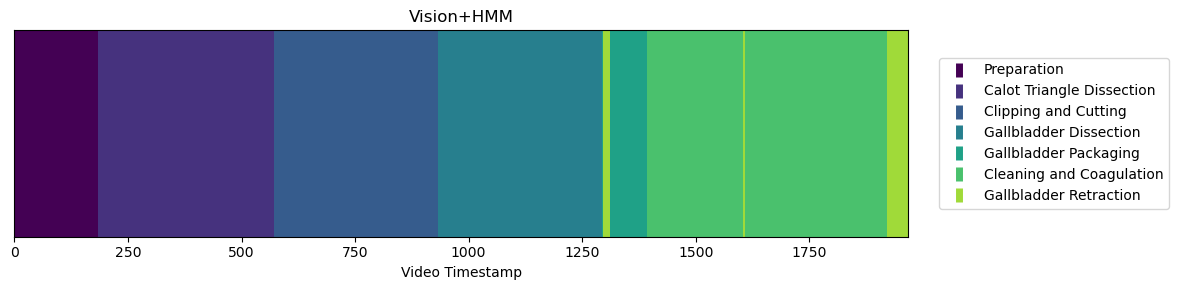

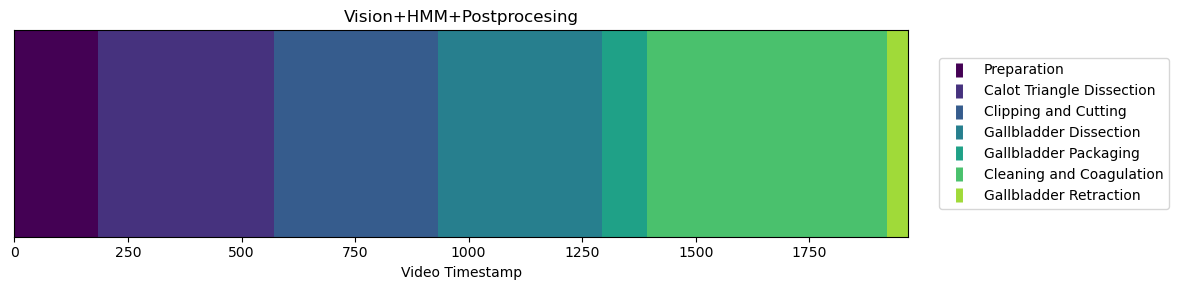

Start decoding vid video53:  ...


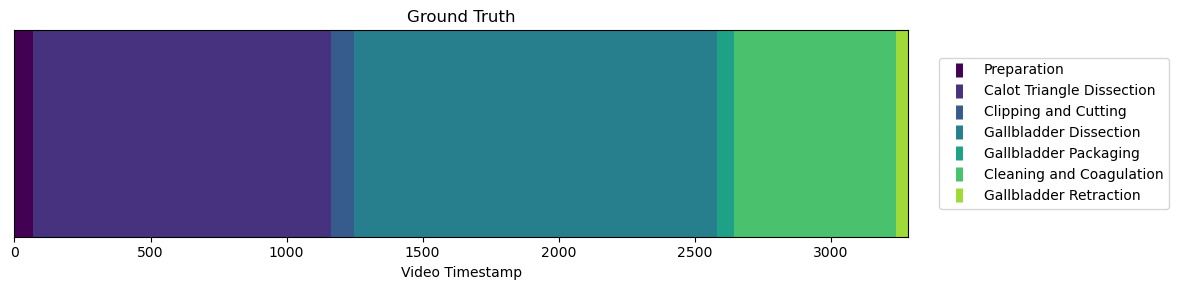

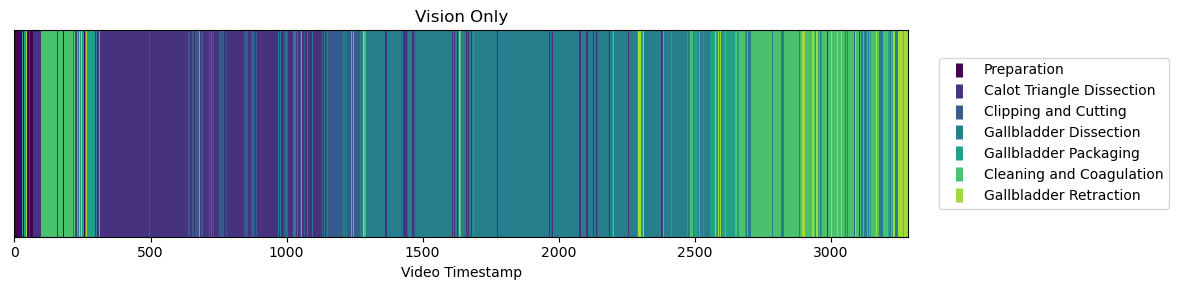

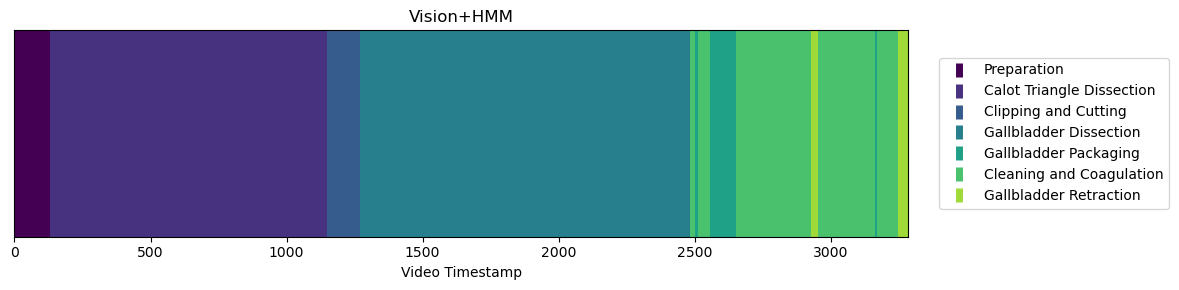

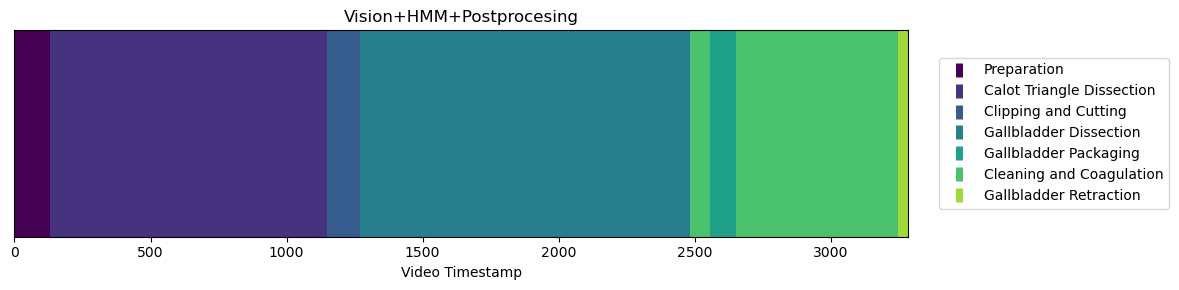

Start decoding vid video54:  ...


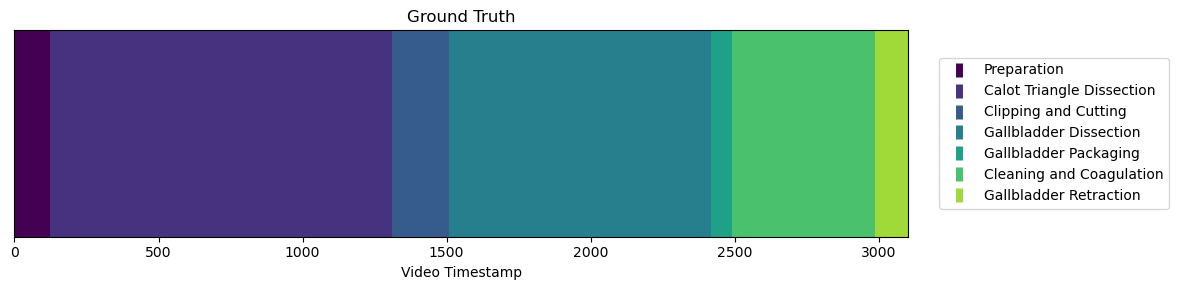

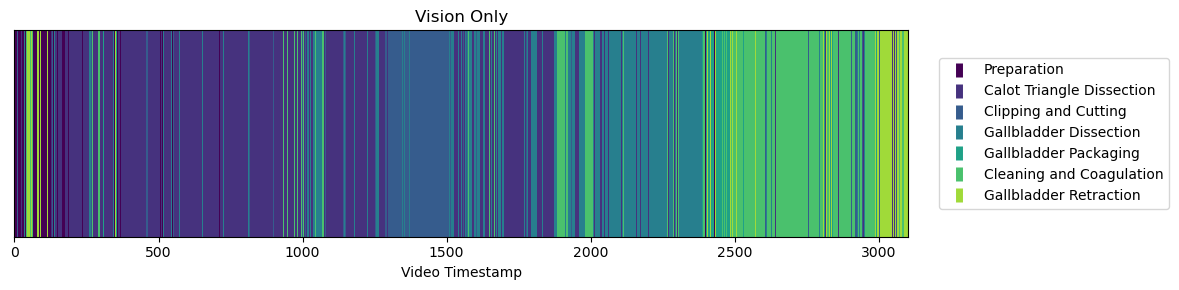

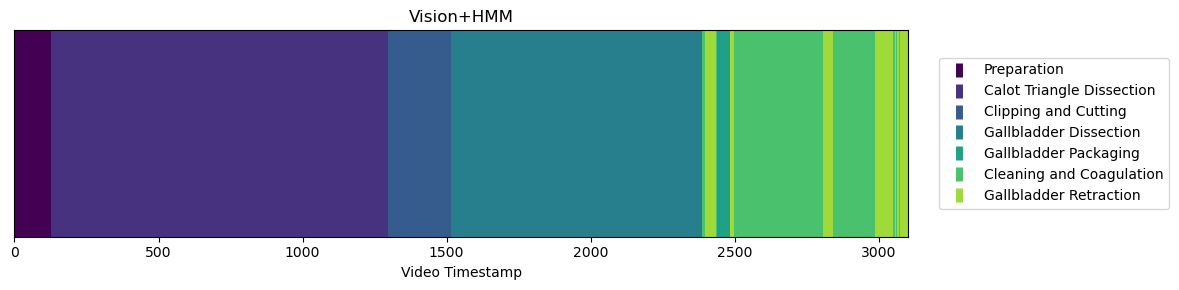

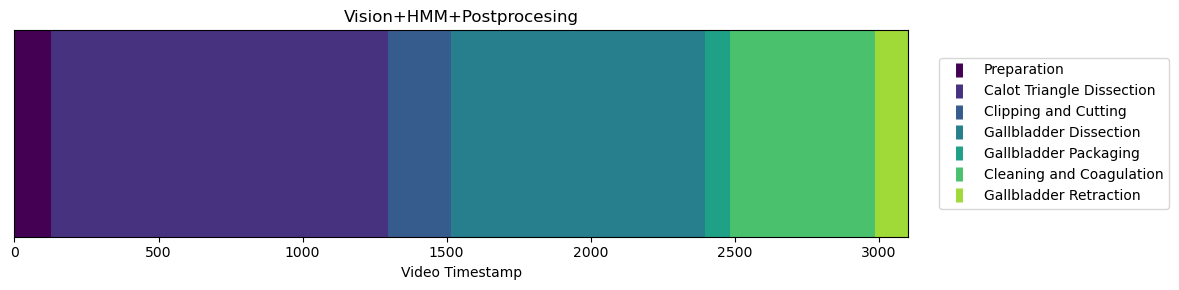

Start decoding vid video55:  ...


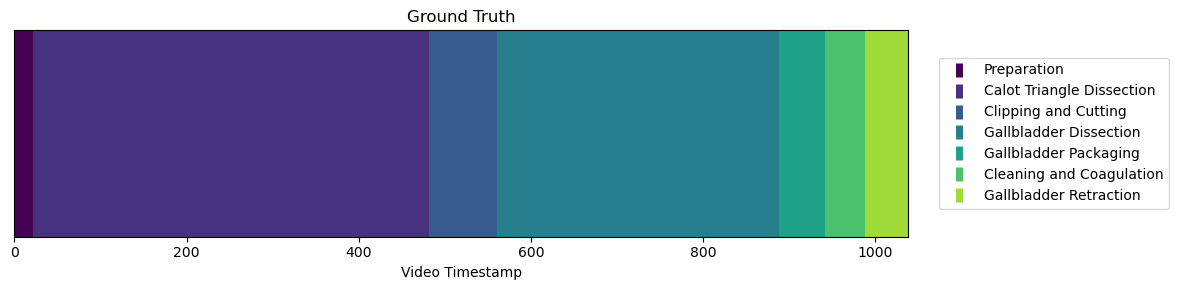

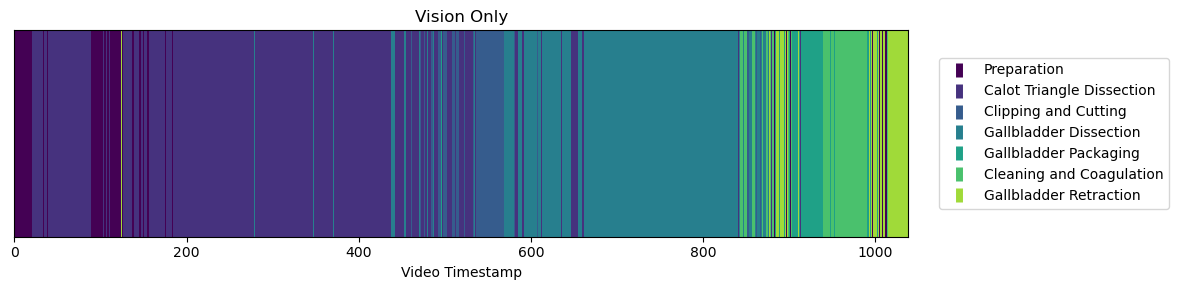

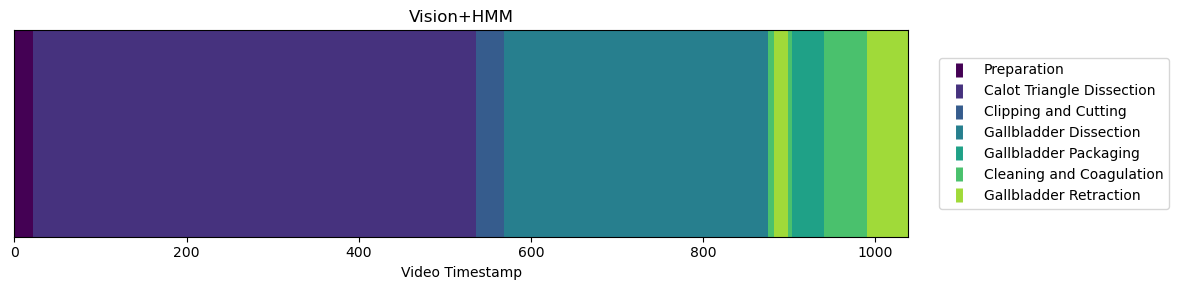

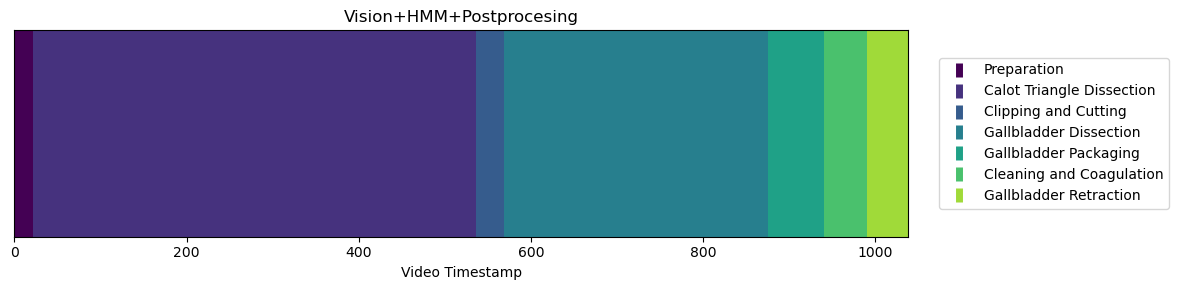

Start decoding vid video56:  ...


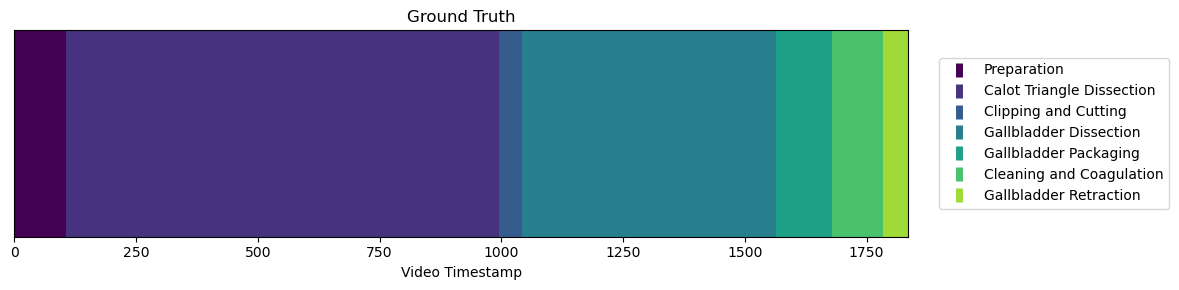

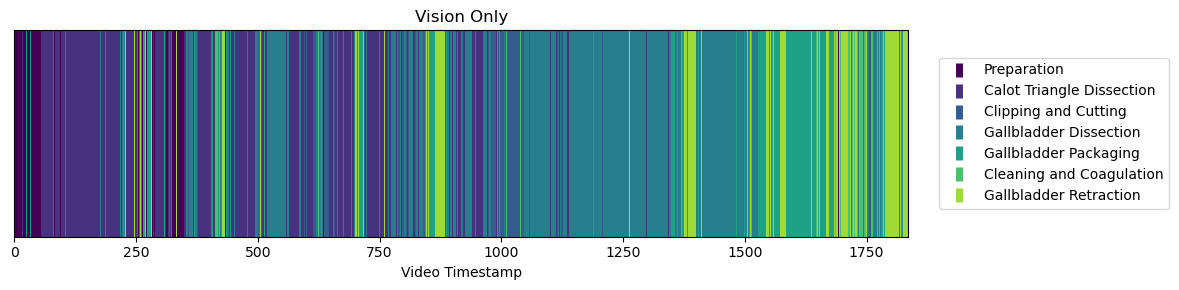

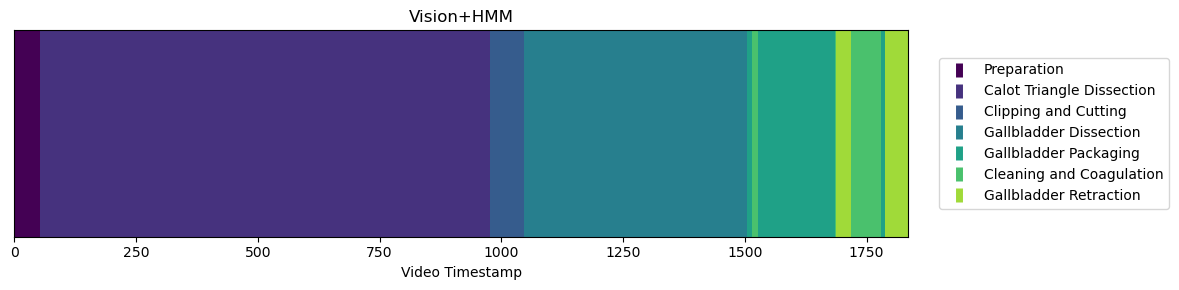

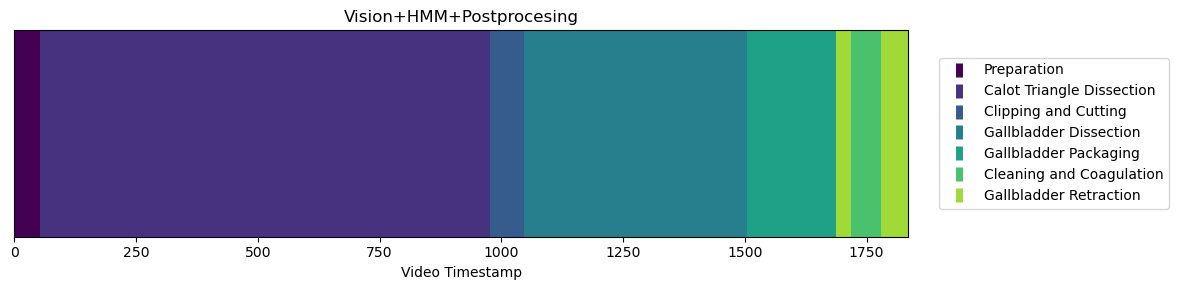

Start decoding vid video57:  ...


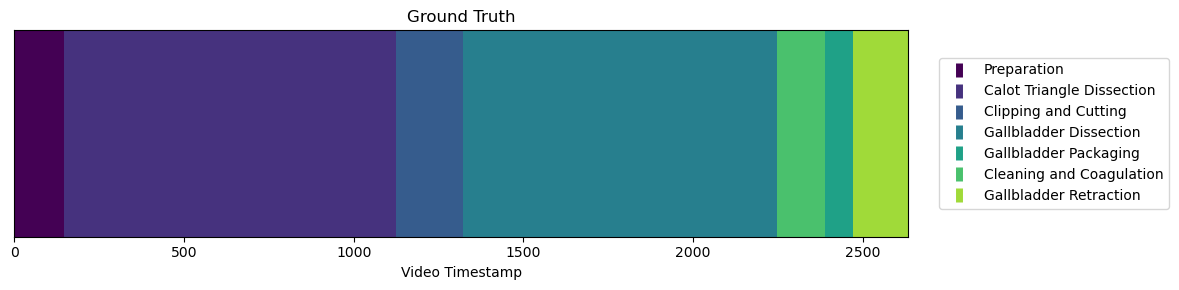

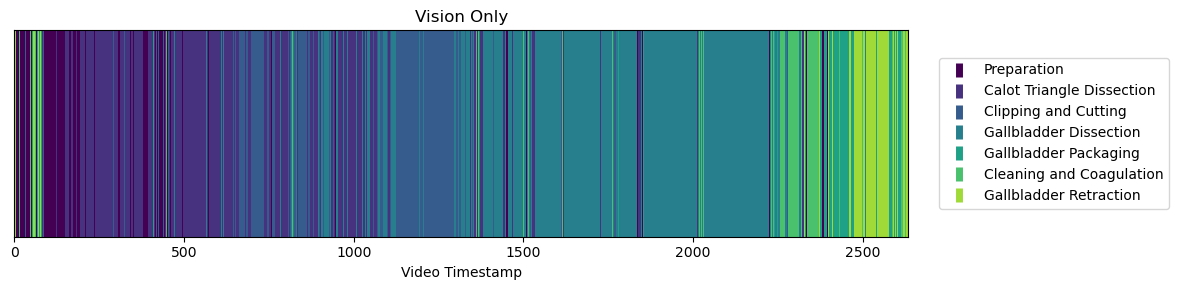

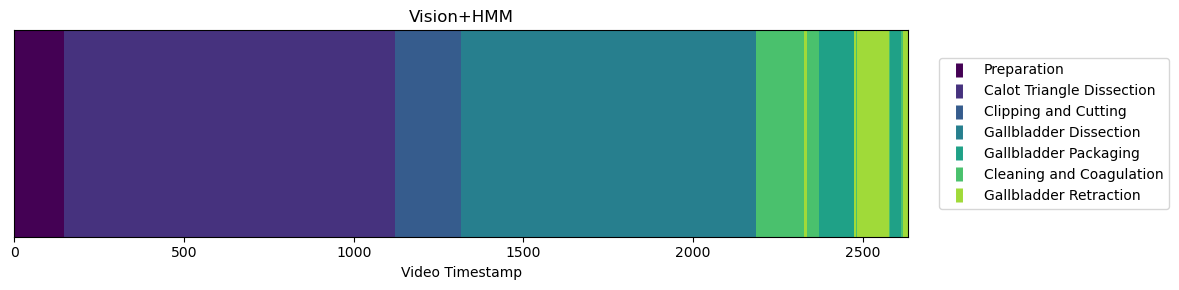

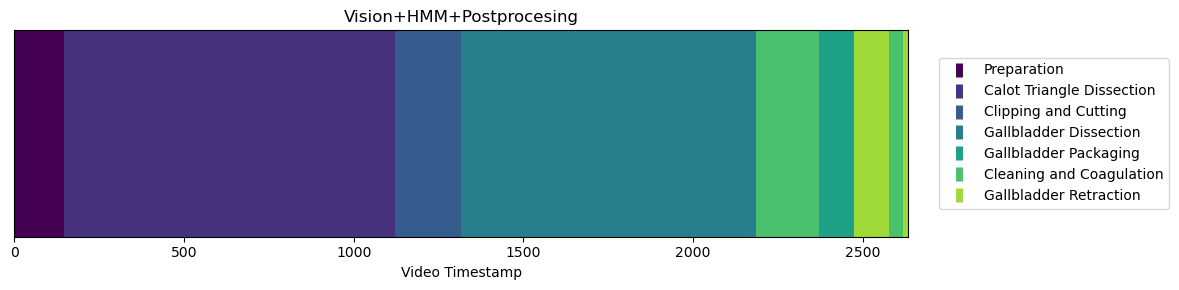

Start decoding vid video58:  ...


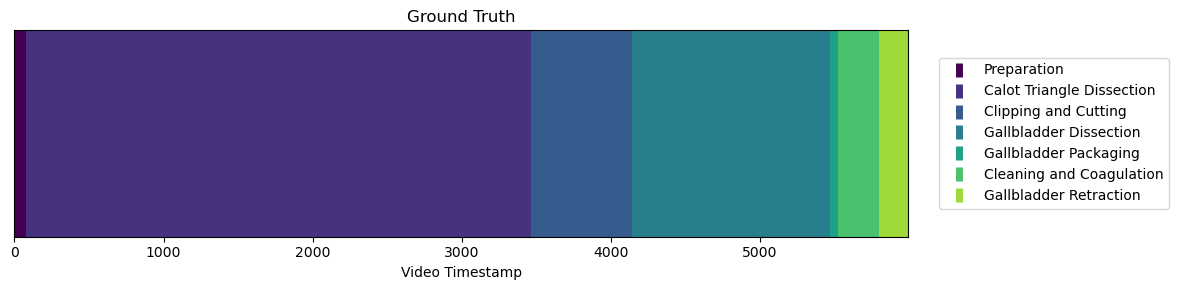

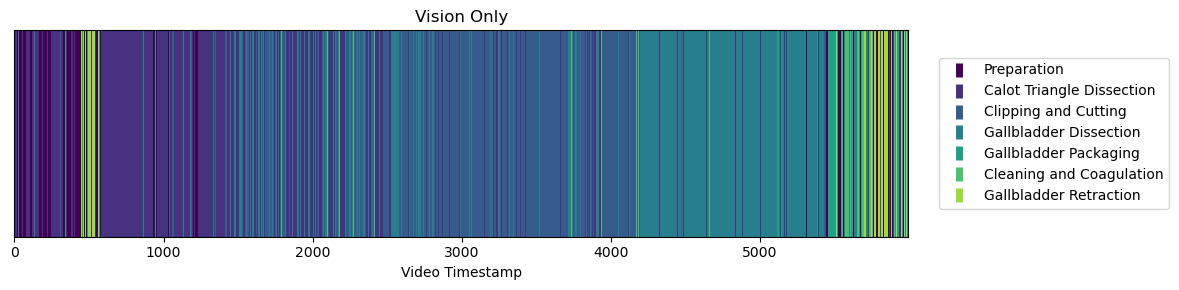

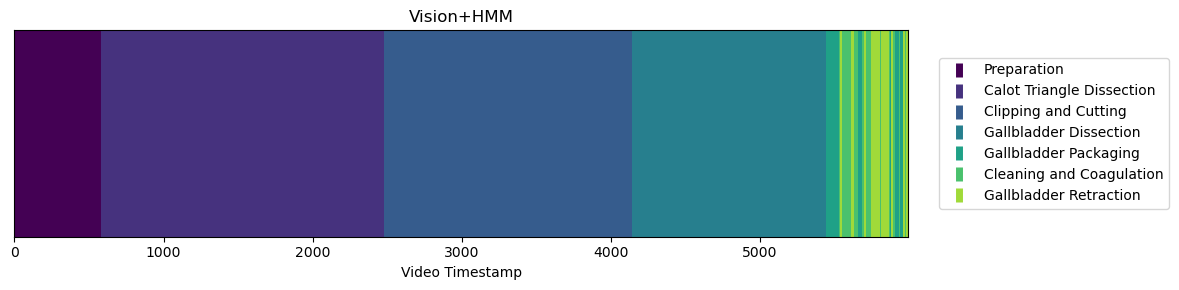

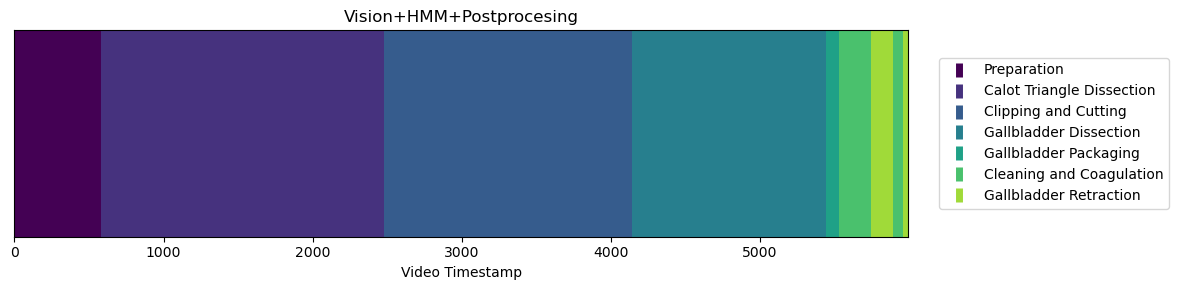

Start decoding vid video59:  ...


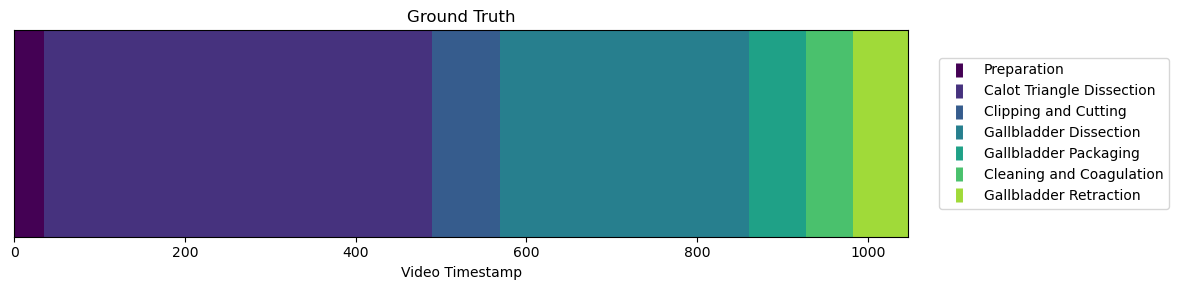

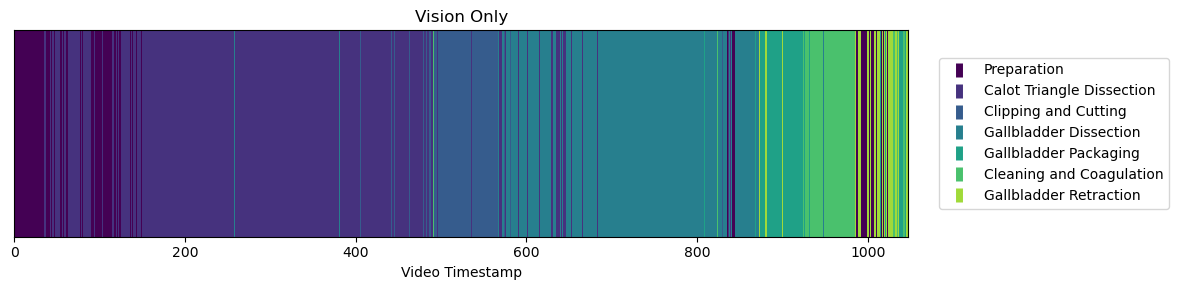

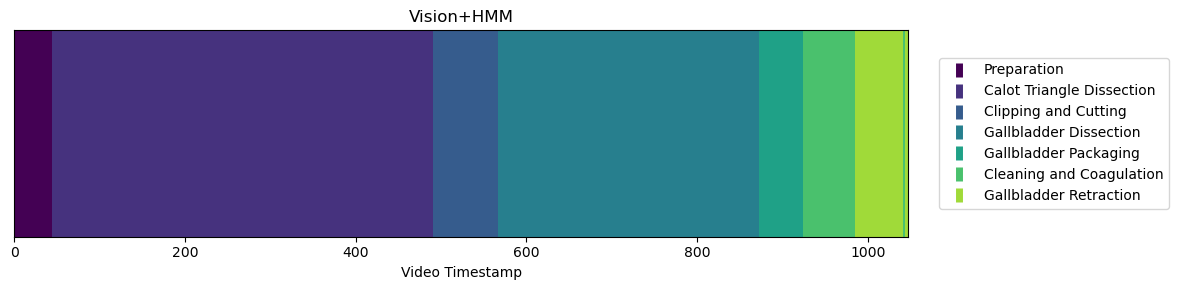

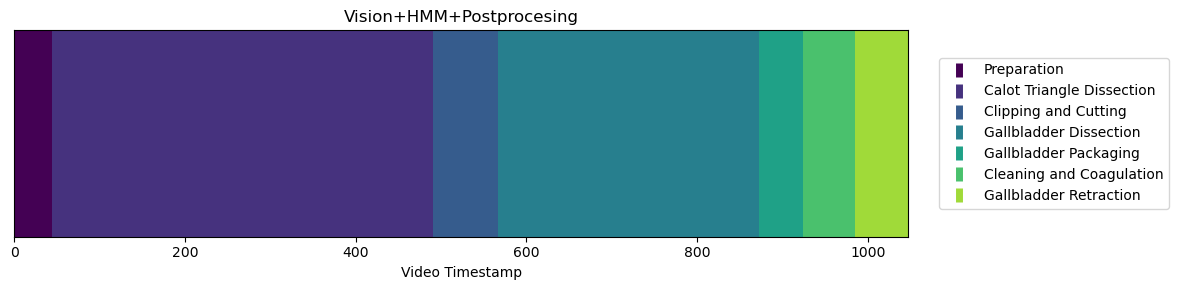

Start decoding vid video60:  ...


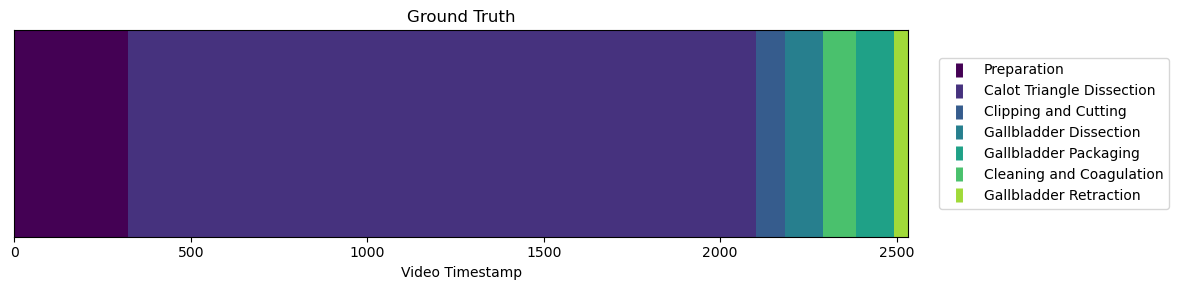

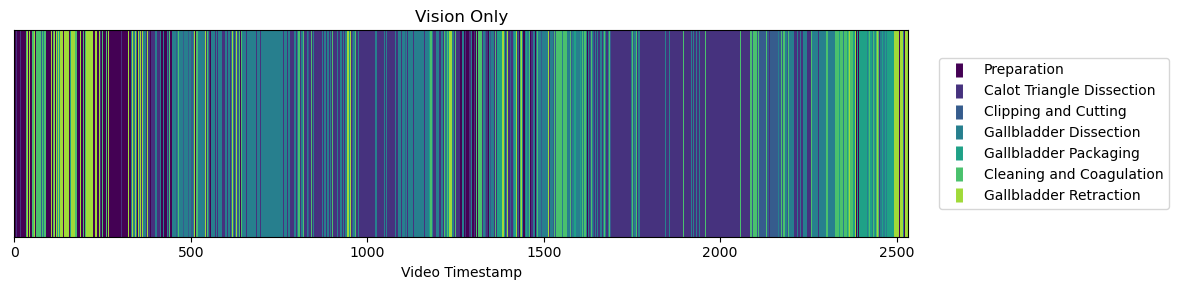

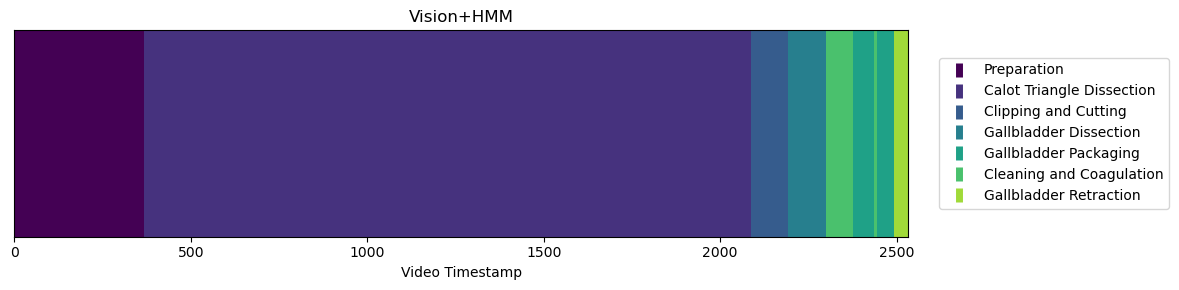

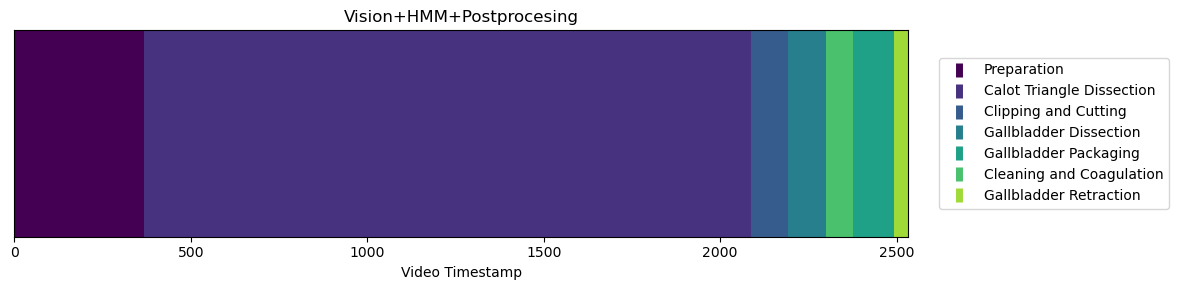

Start decoding vid video61:  ...


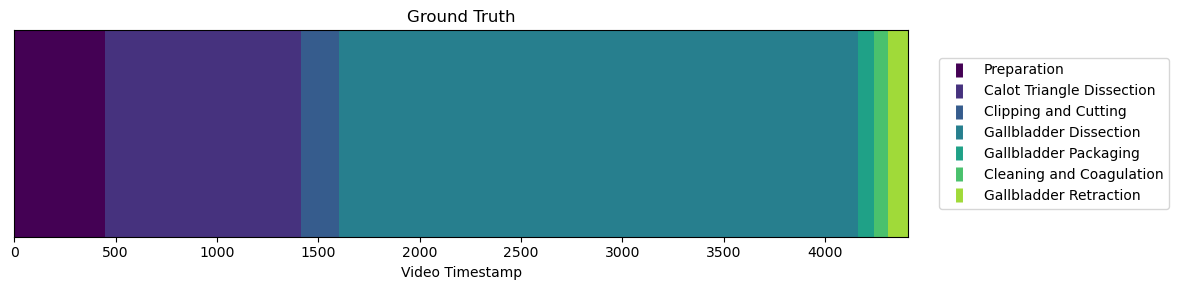

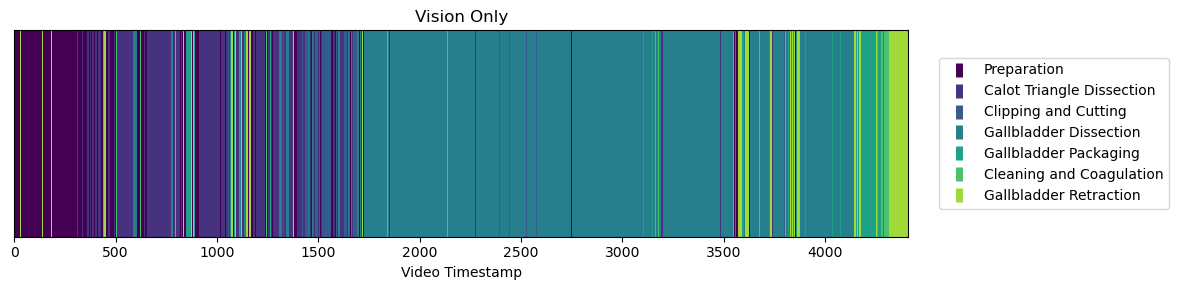

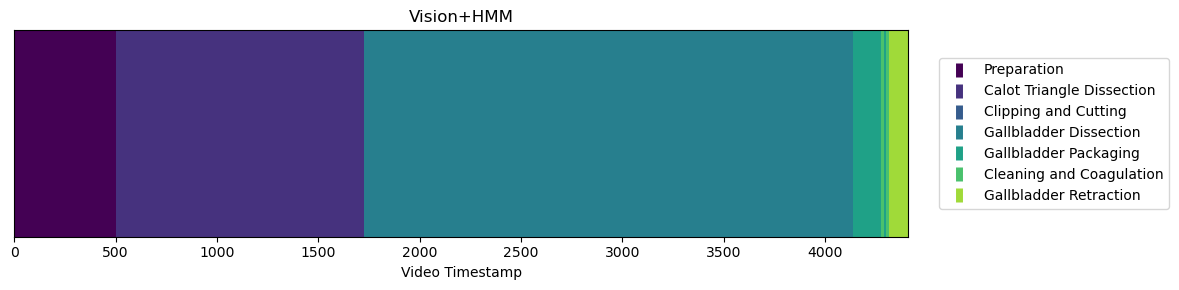

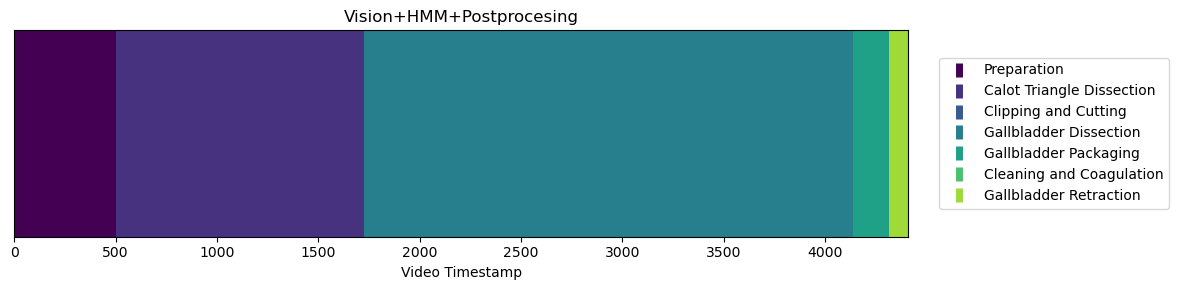

Start decoding vid video62:  ...


c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classifi

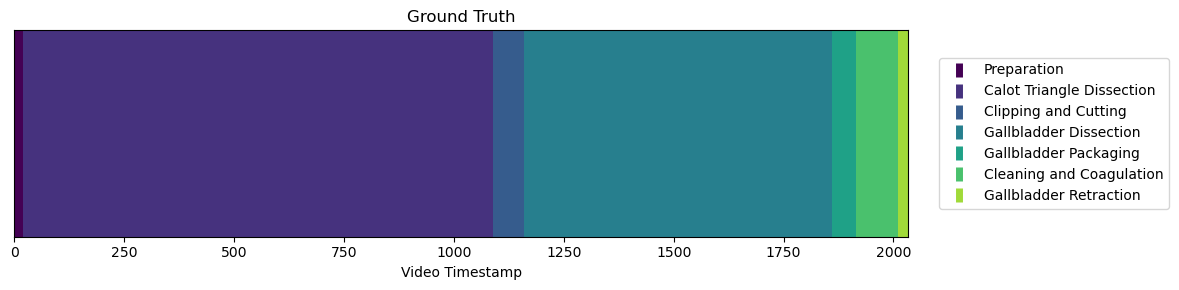

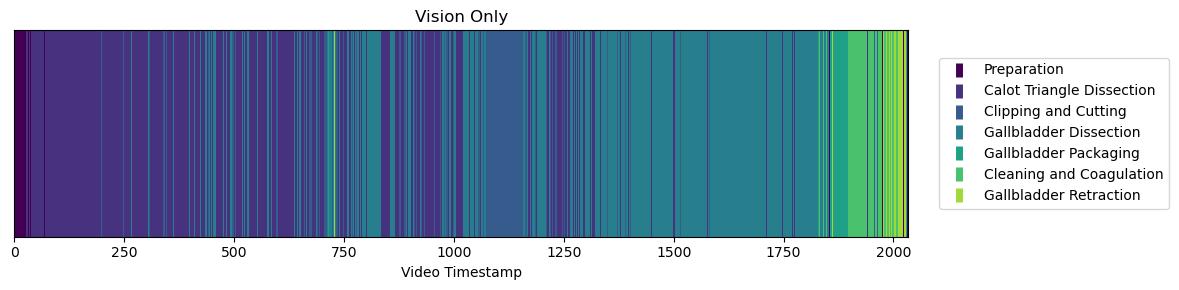

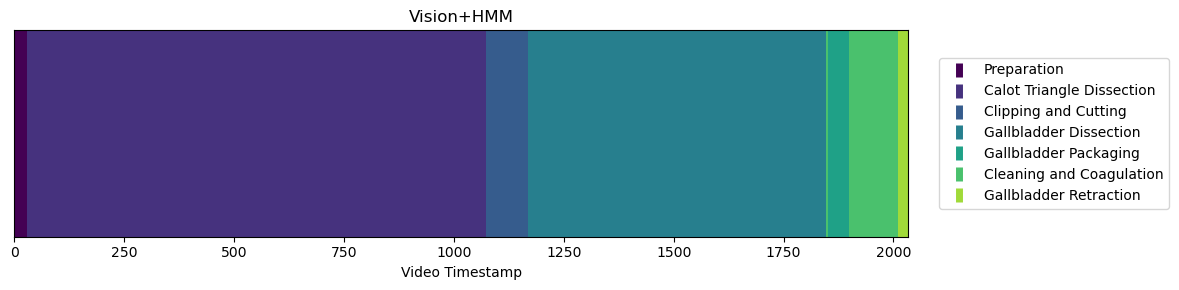

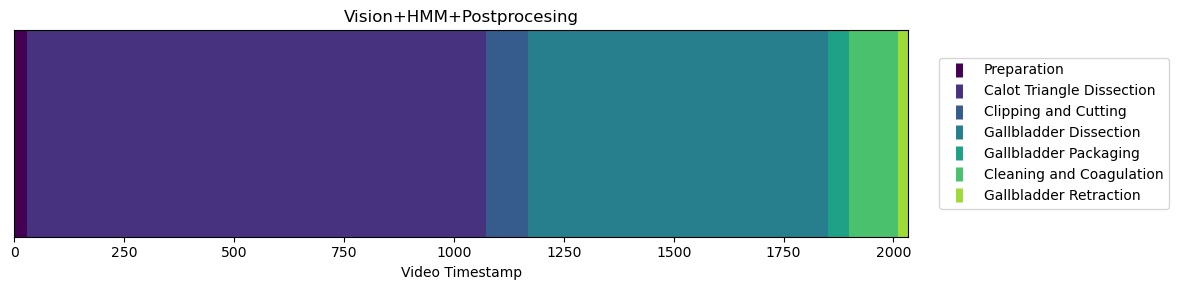

Start decoding vid video63:  ...


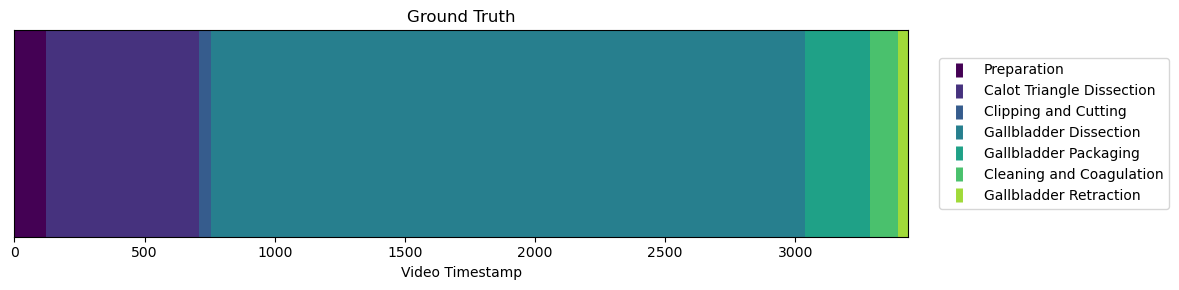

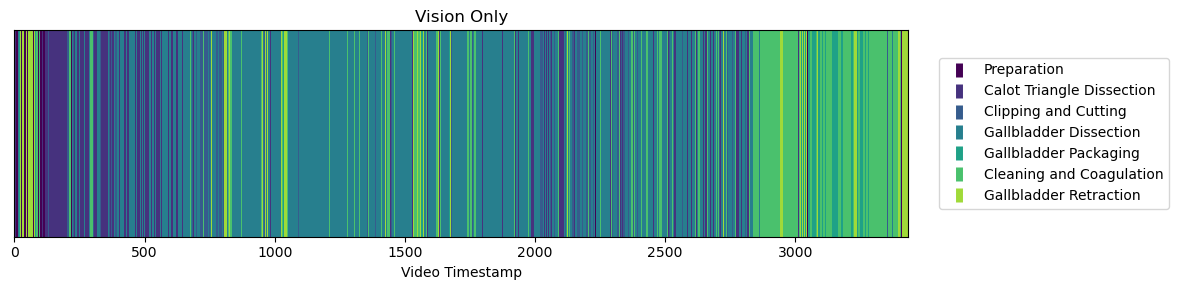

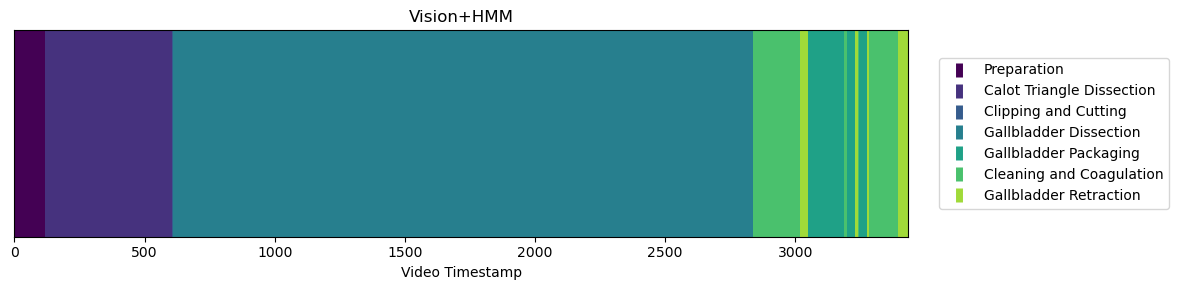

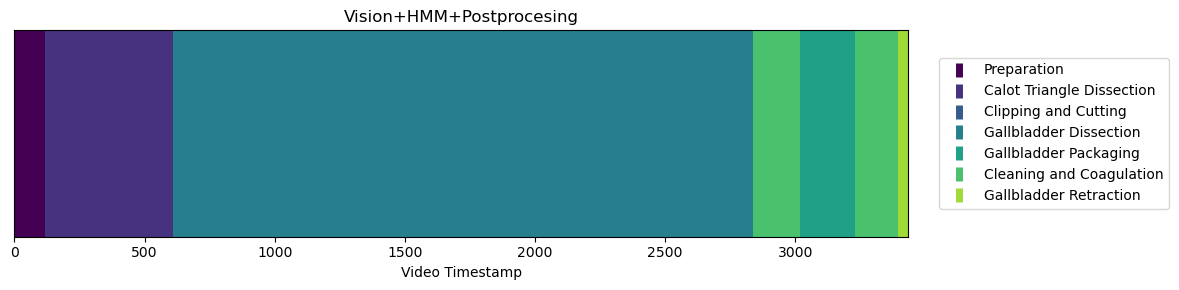

Start decoding vid video64:  ...


c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classifi

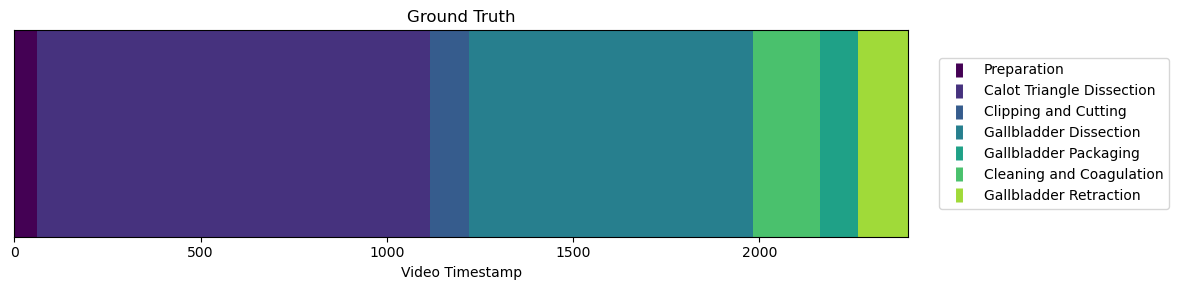

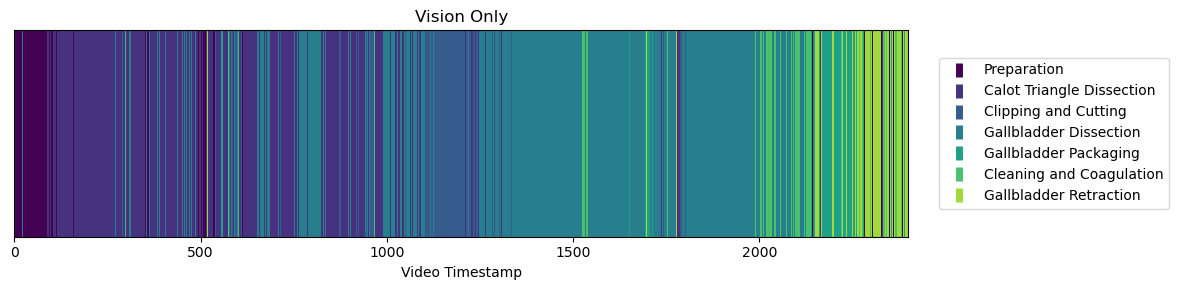

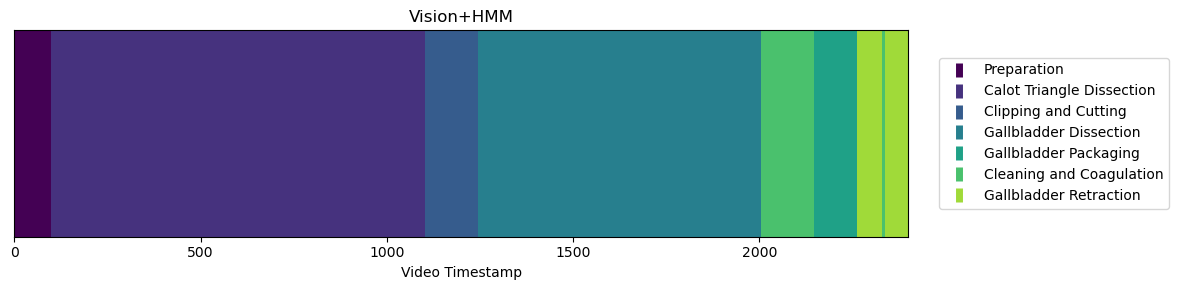

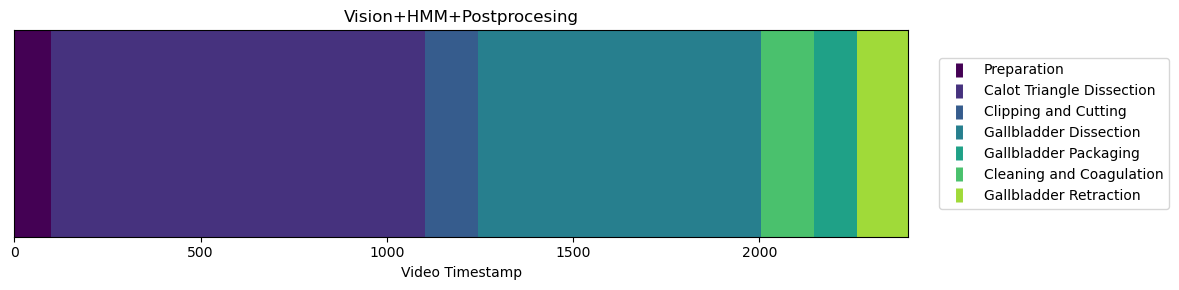

Start decoding vid video65:  ...


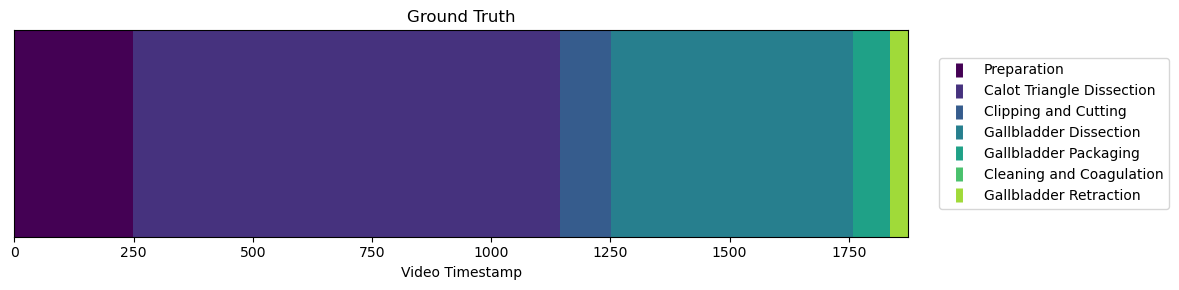

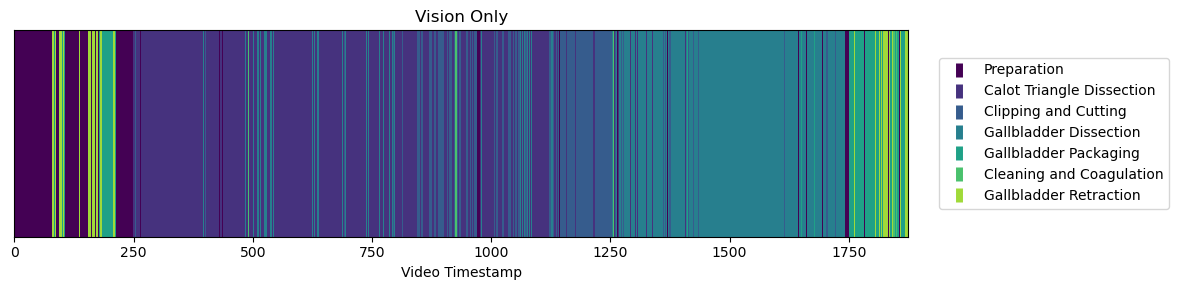

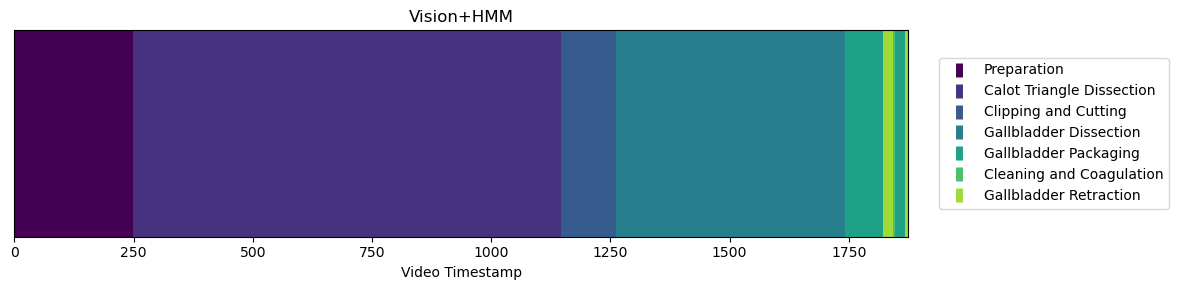

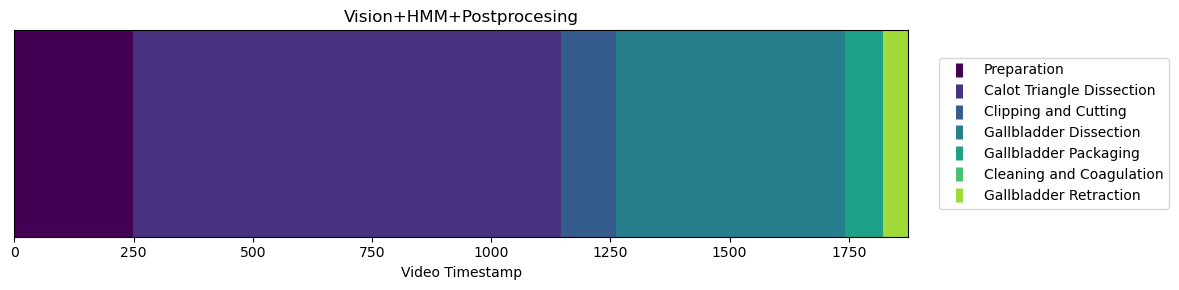

Start decoding vid video66:  ...


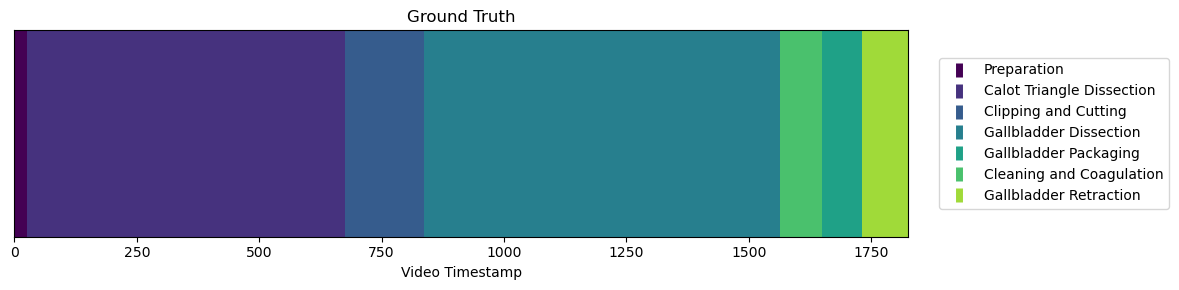

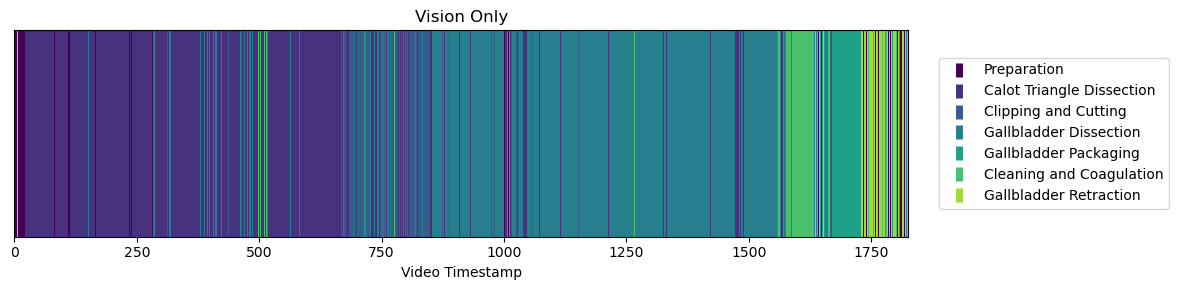

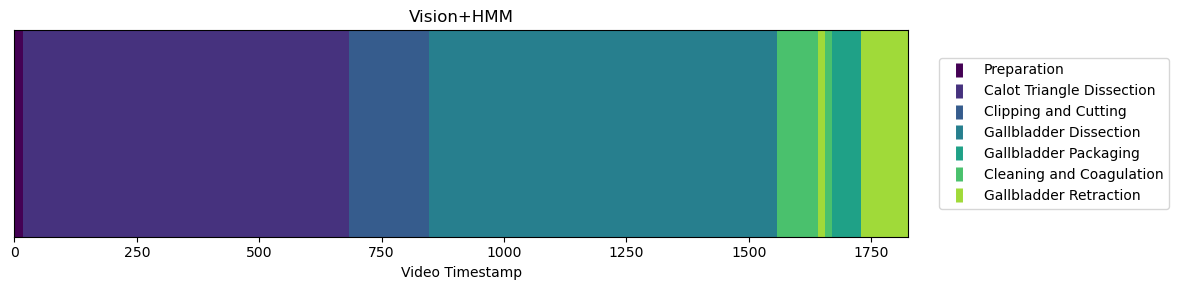

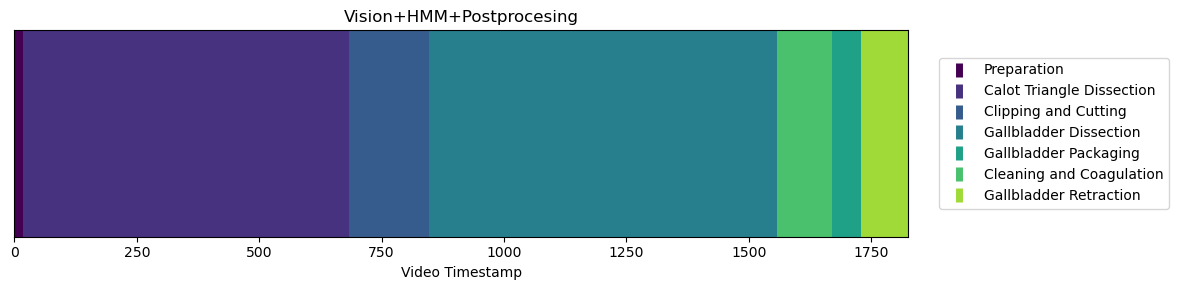

Start decoding vid video67:  ...


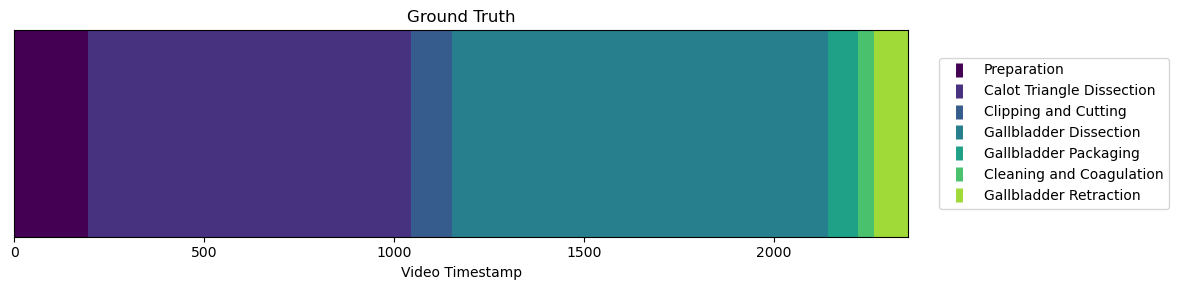

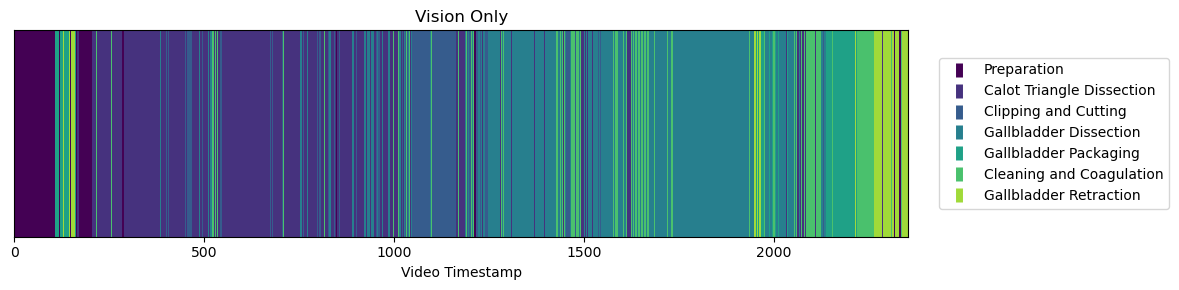

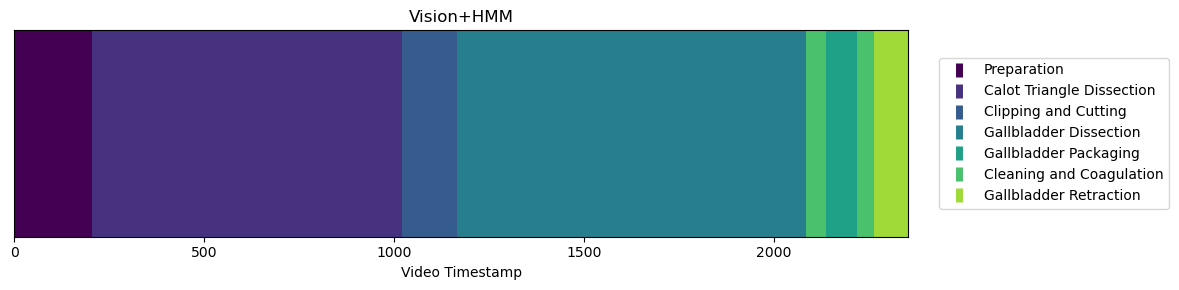

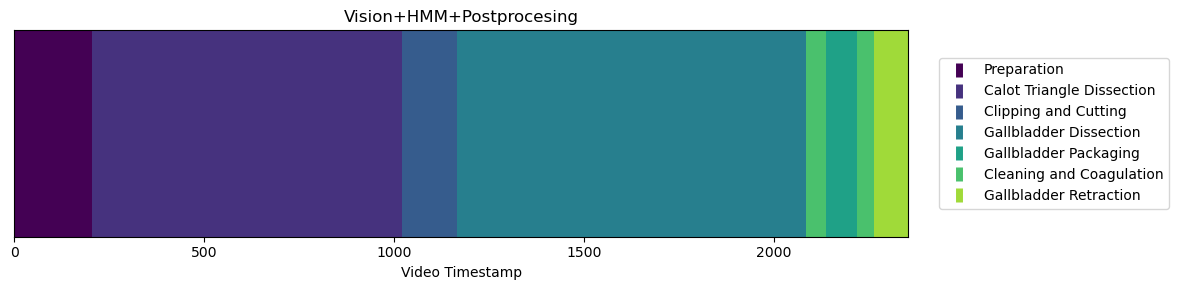

Start decoding vid video68:  ...


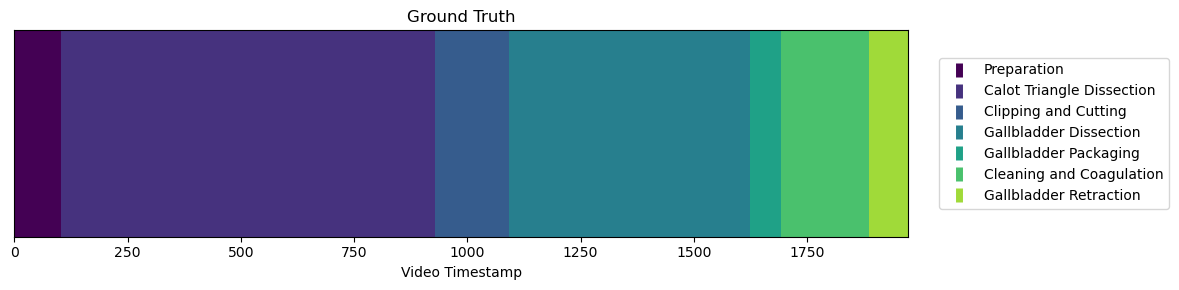

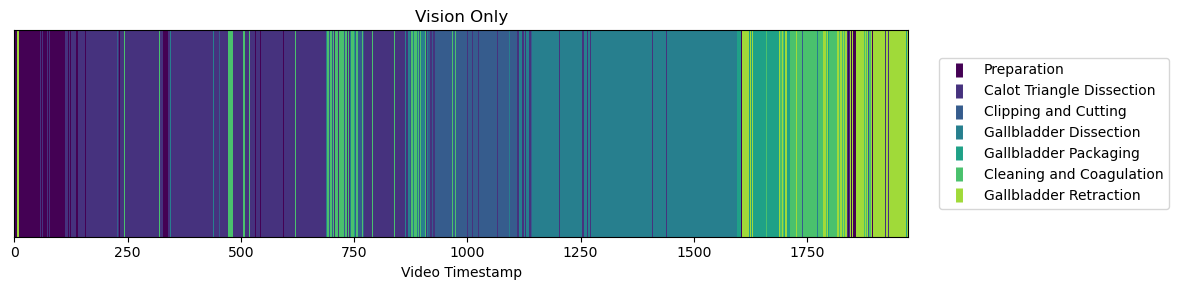

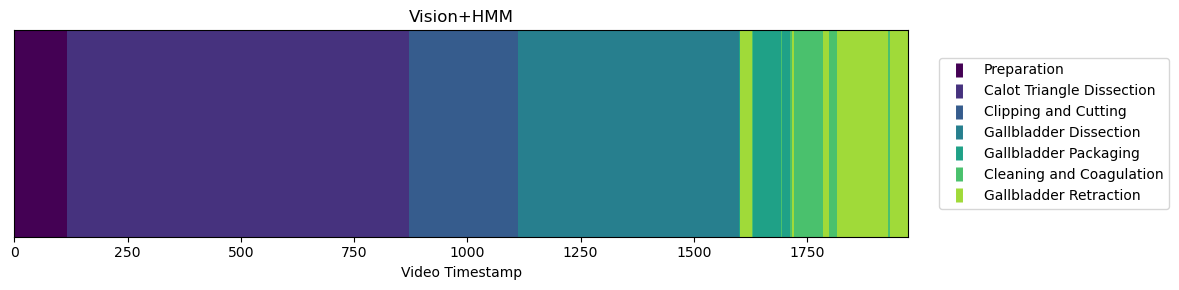

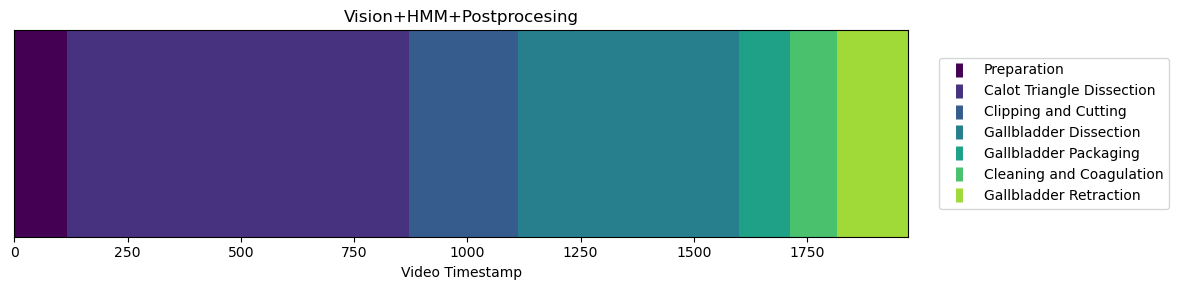

Start decoding vid video69:  ...


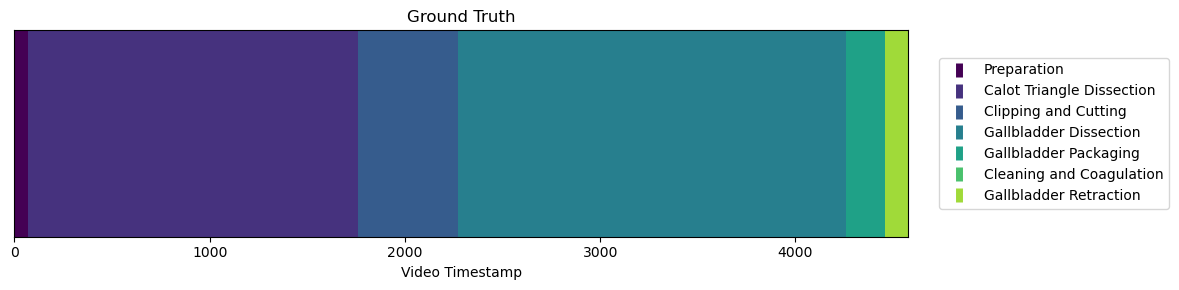

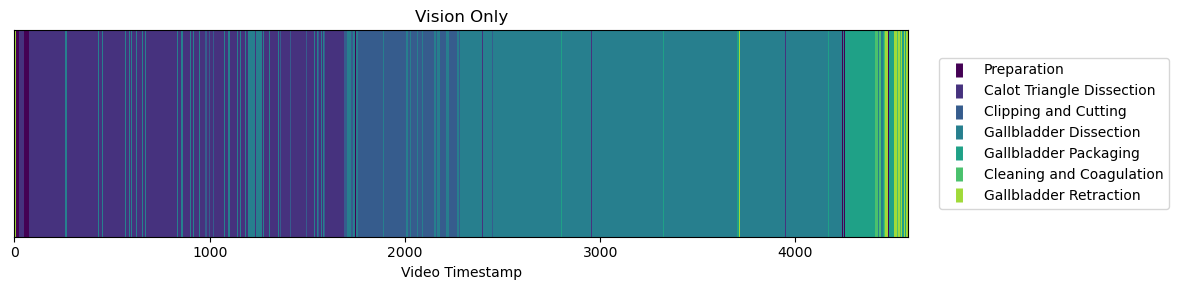

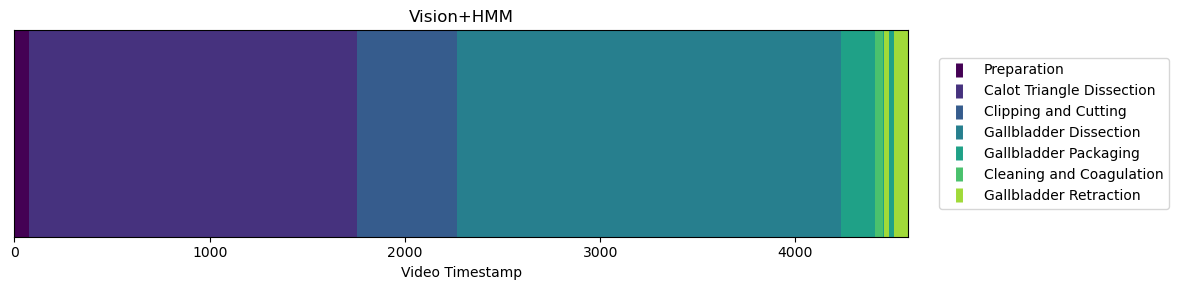

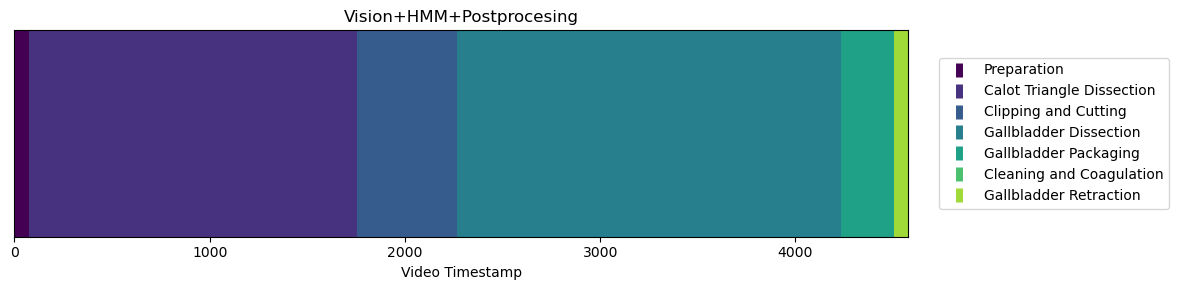

Start decoding vid video70:  ...


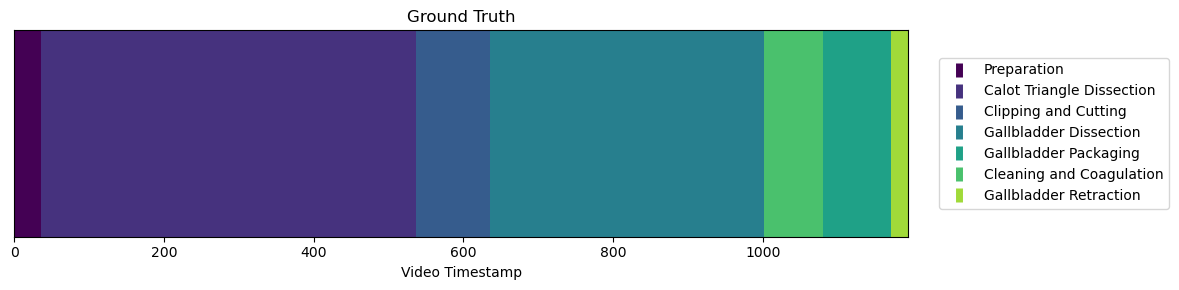

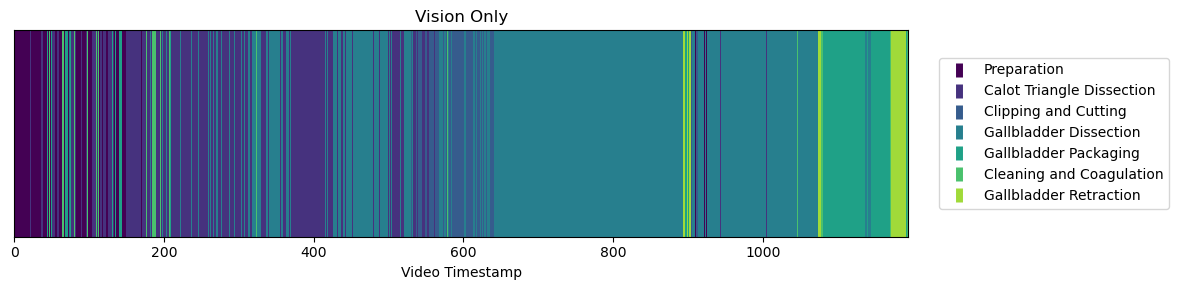

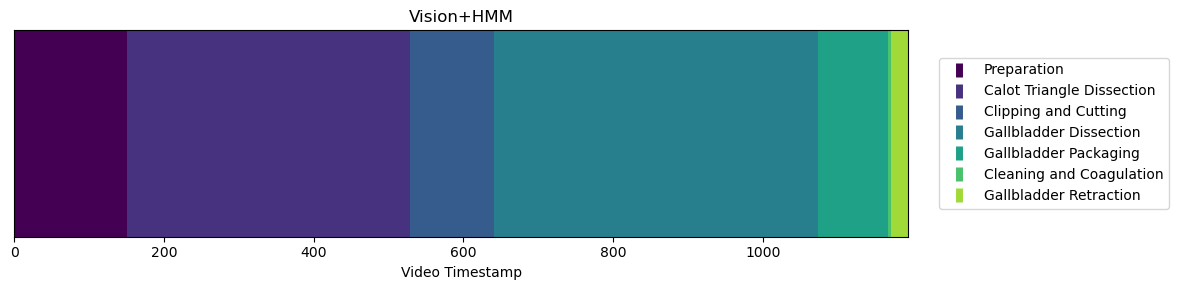

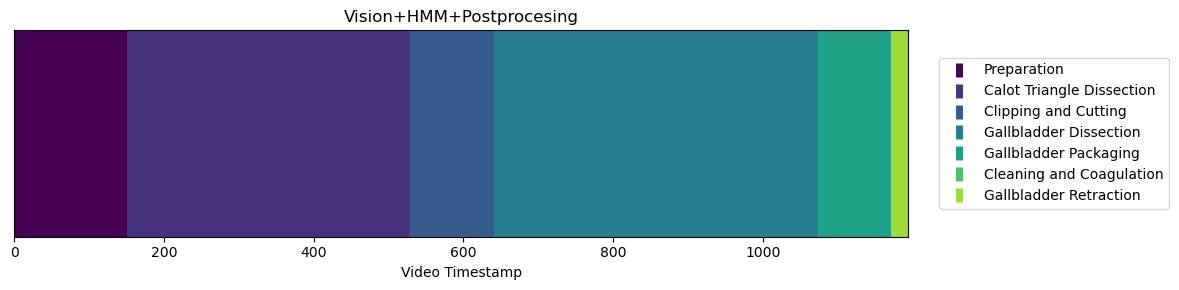

Start decoding vid video71:  ...


c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classifi

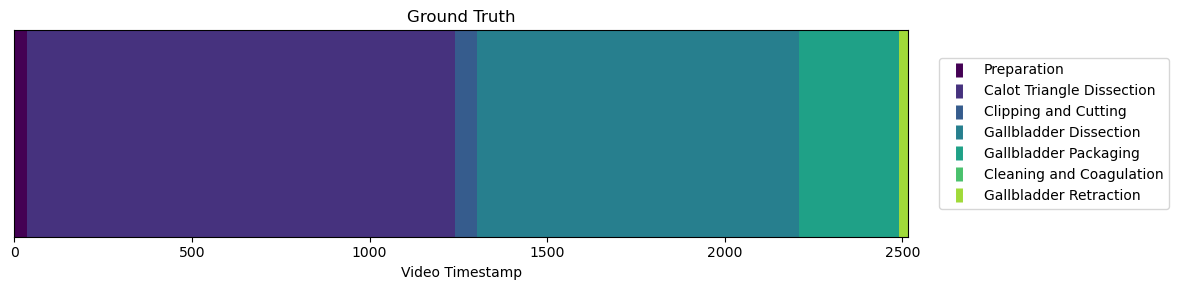

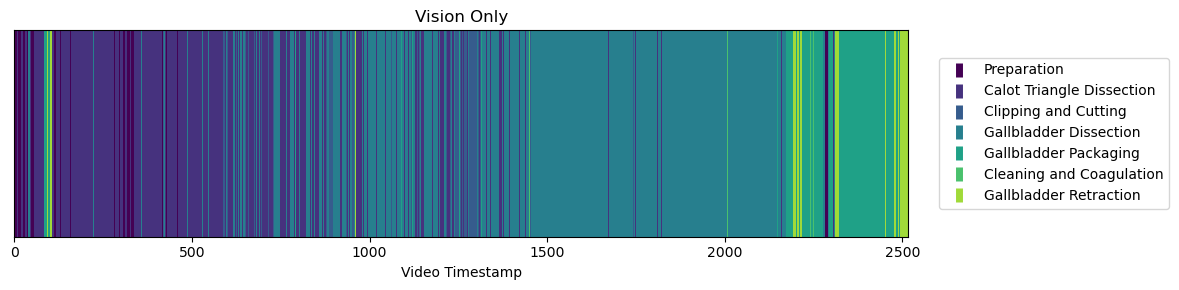

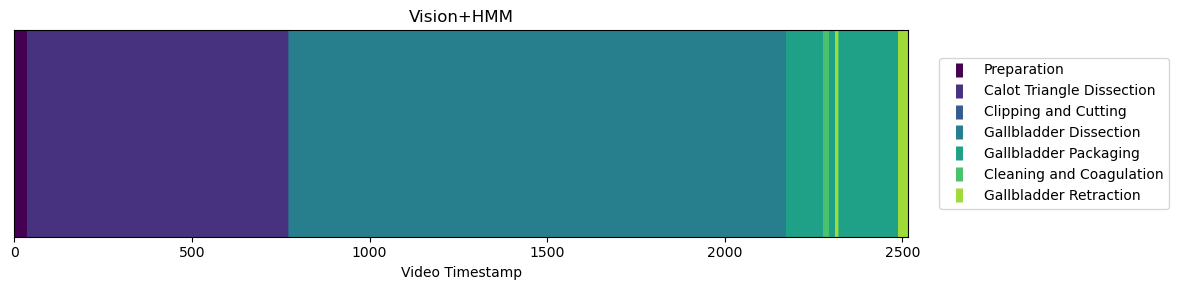

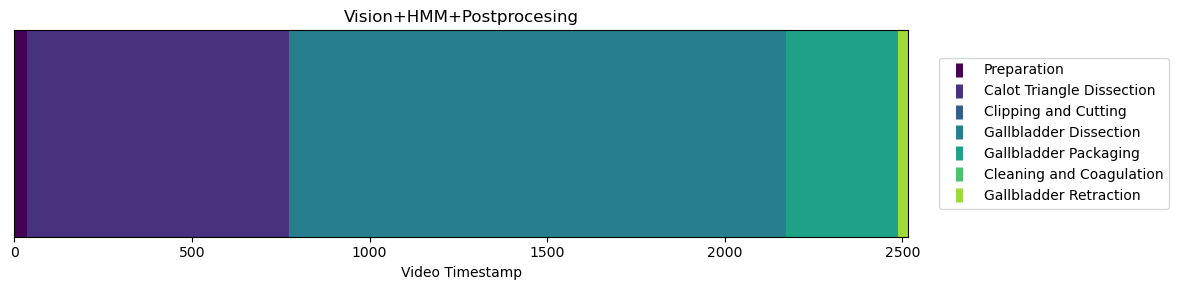

Start decoding vid video72:  ...


c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classifi

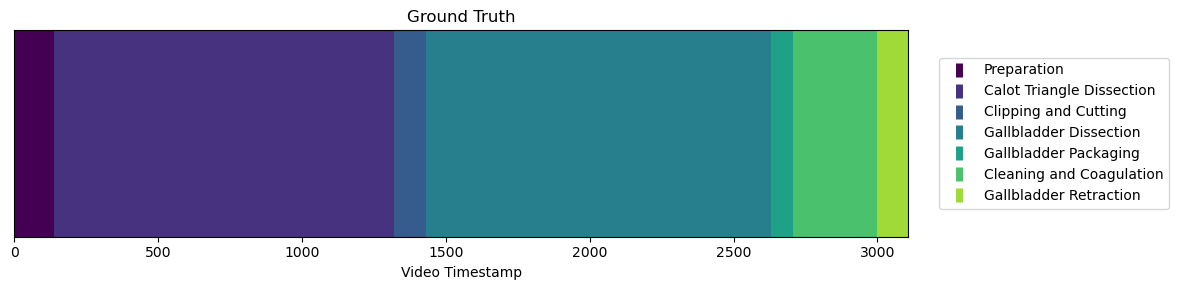

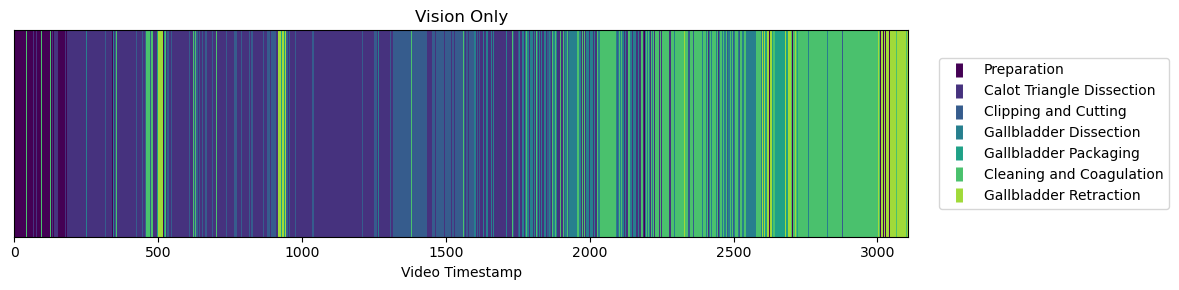

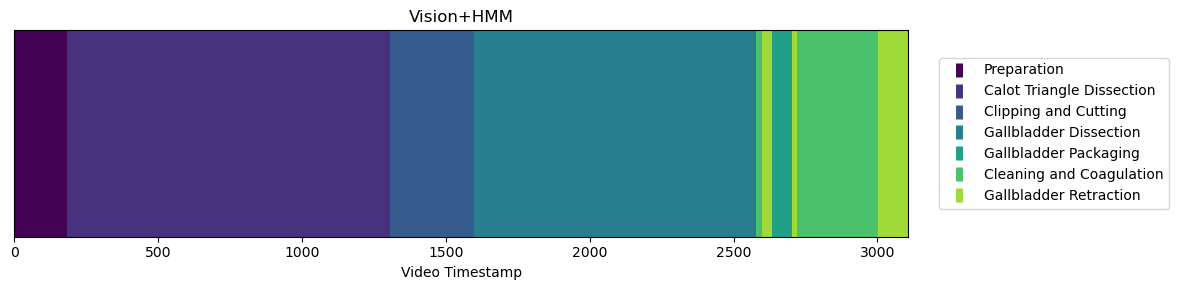

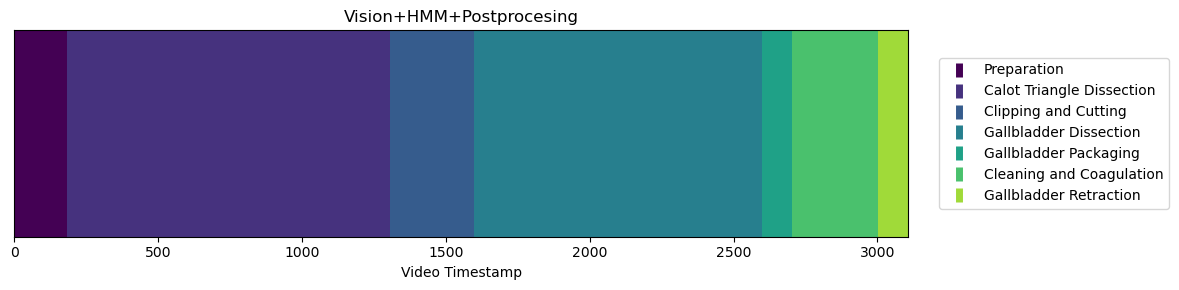

Start decoding vid video73:  ...


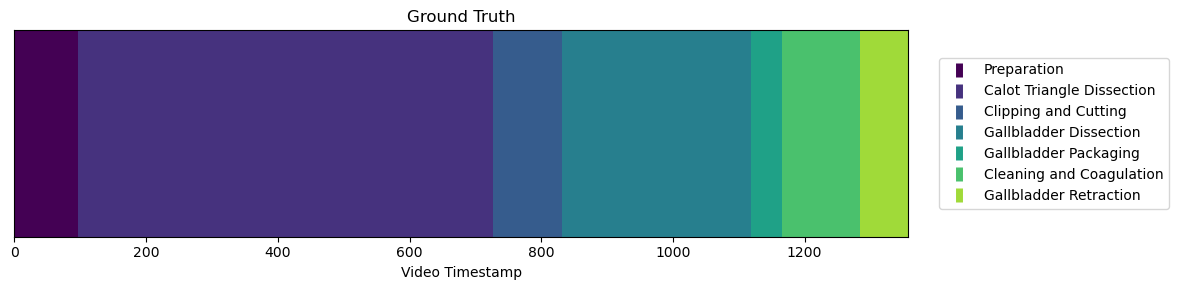

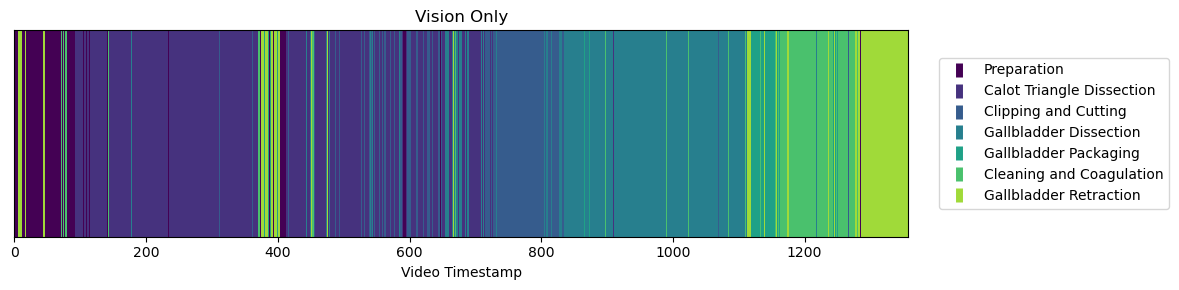

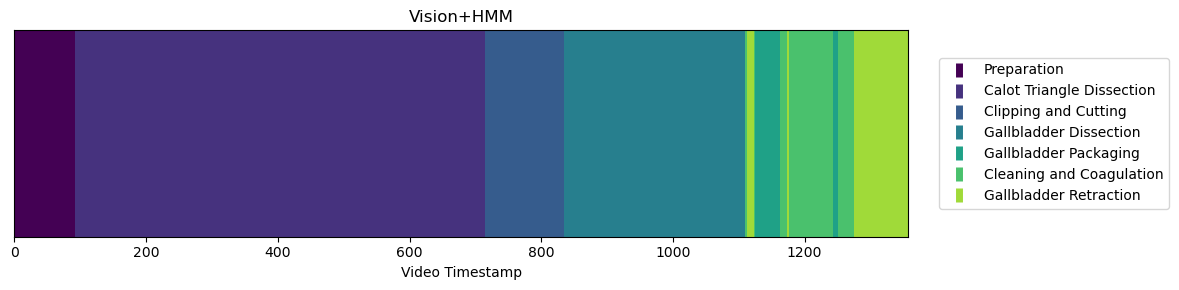

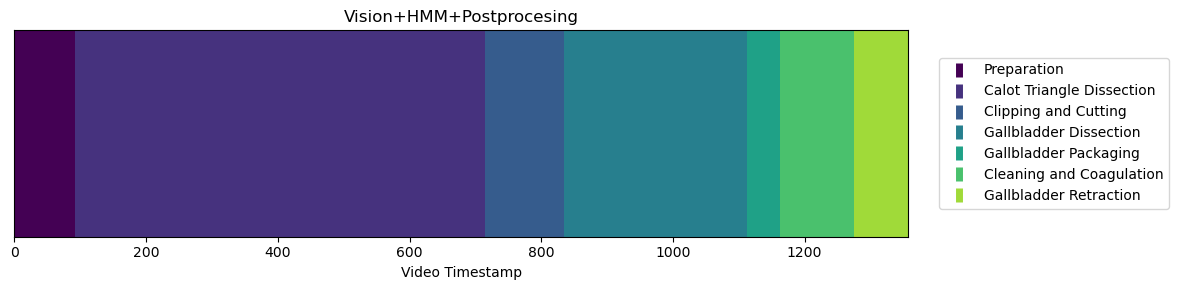

Start decoding vid video74:  ...


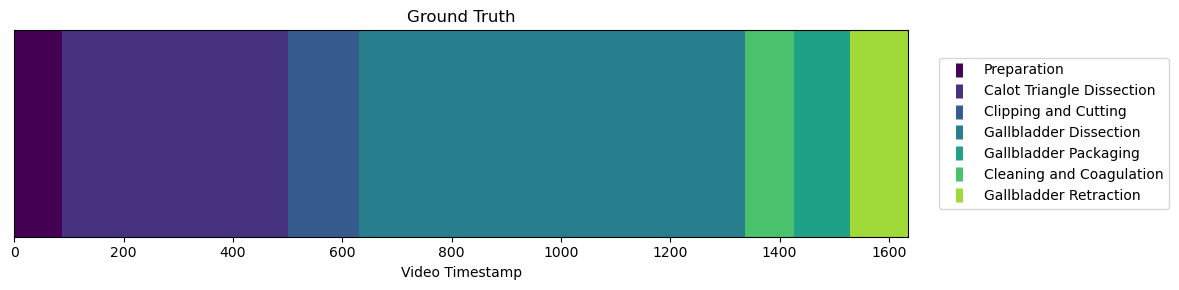

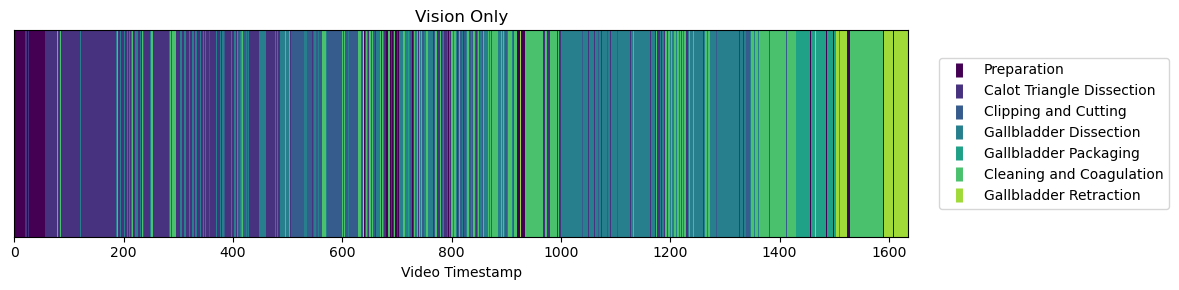

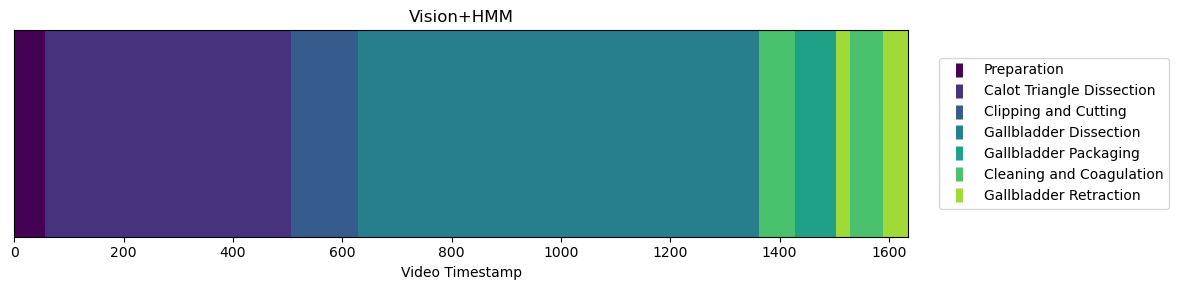

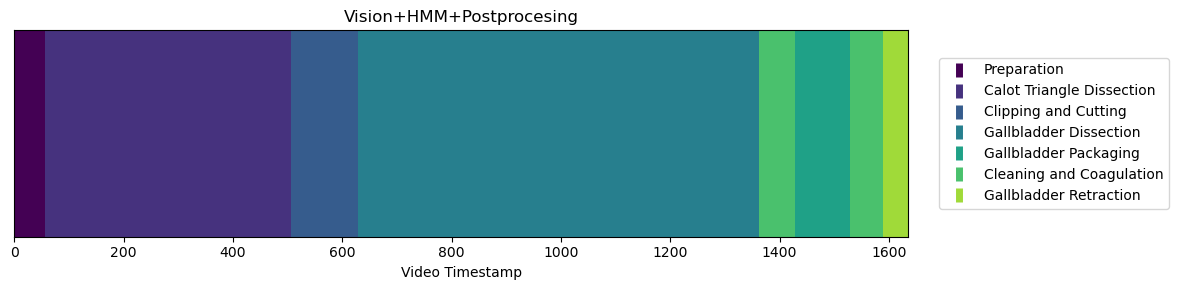

Start decoding vid video75:  ...


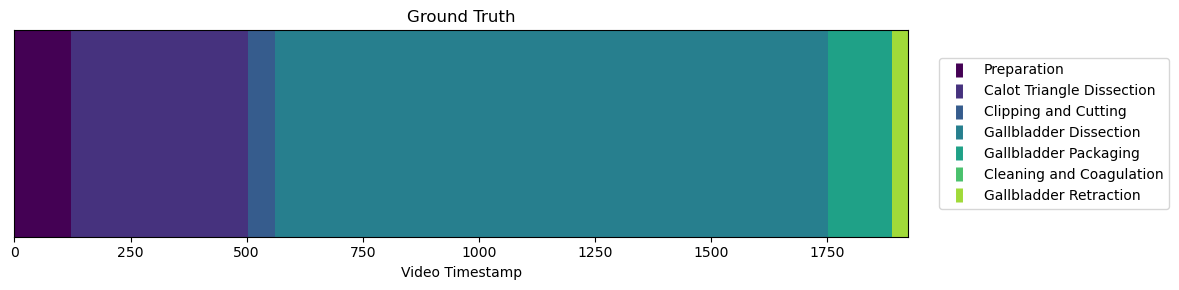

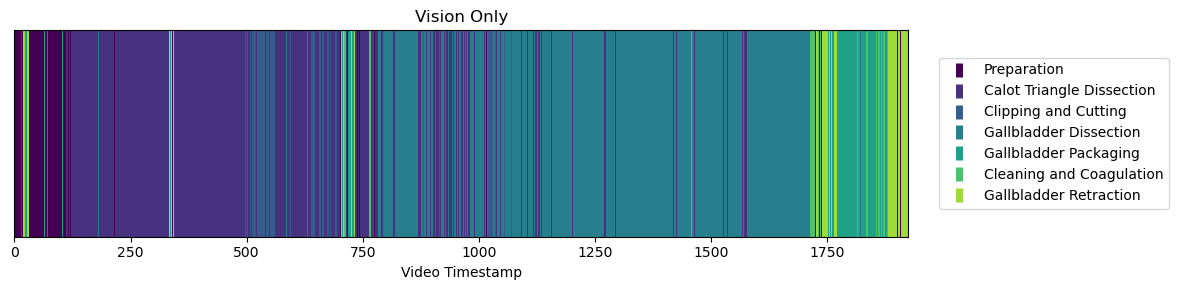

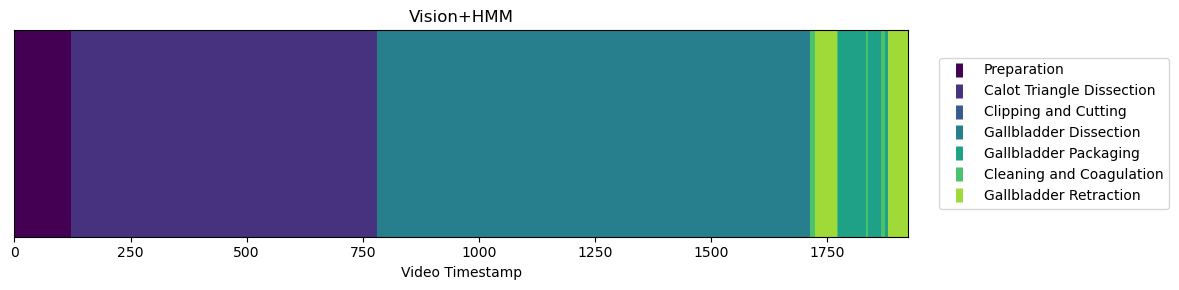

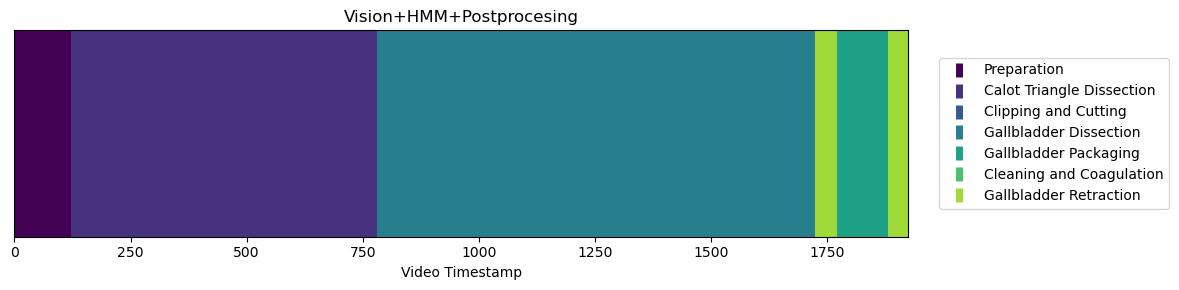

Start decoding vid video76:  ...


c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classifi

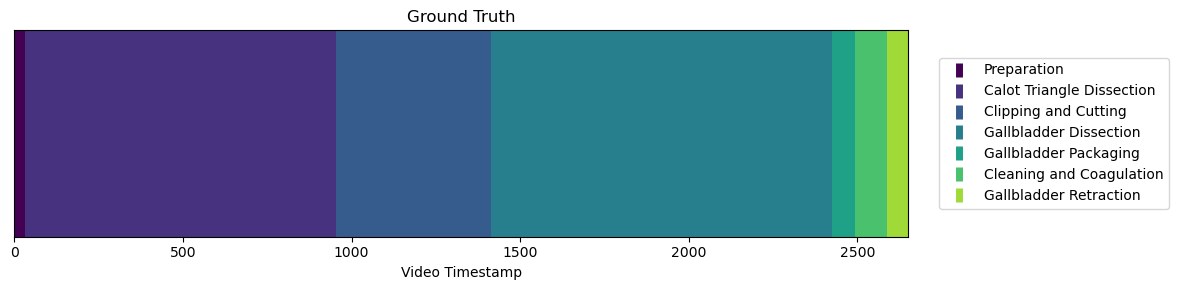

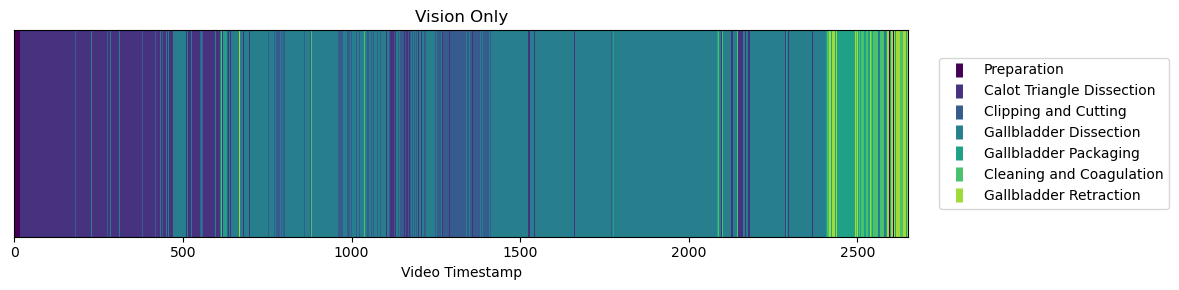

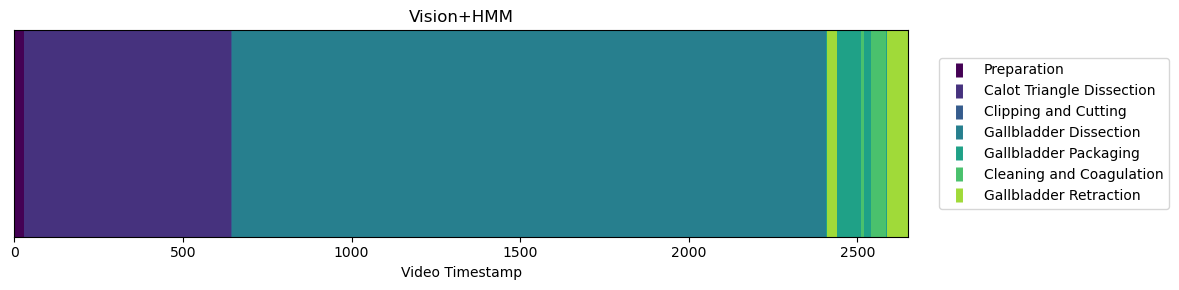

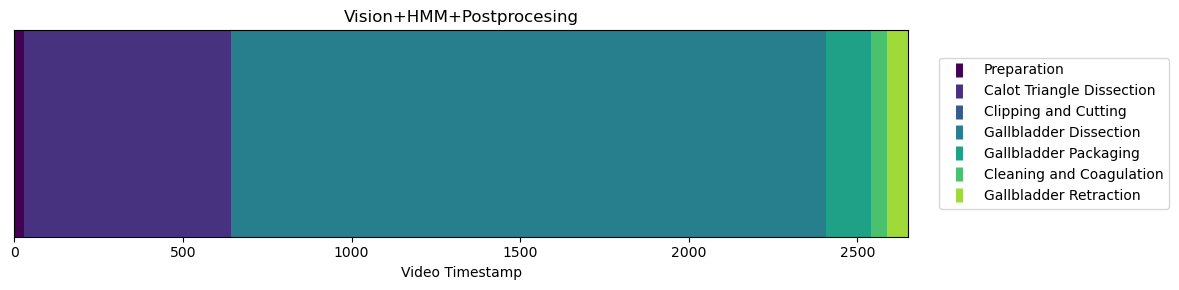

Start decoding vid video77:  ...


c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classifi

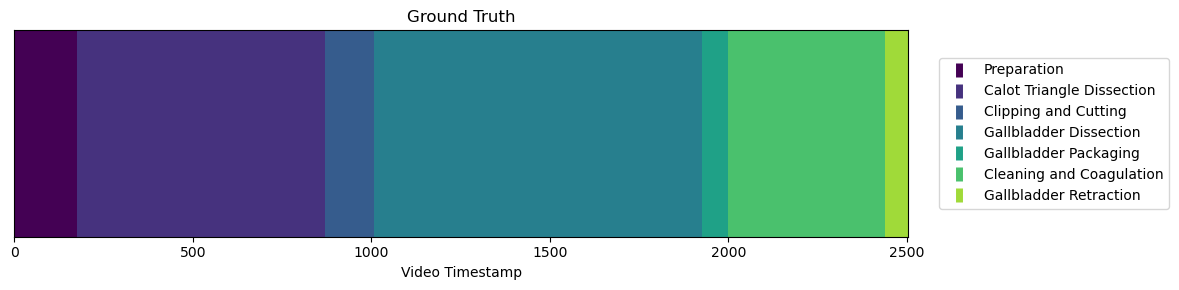

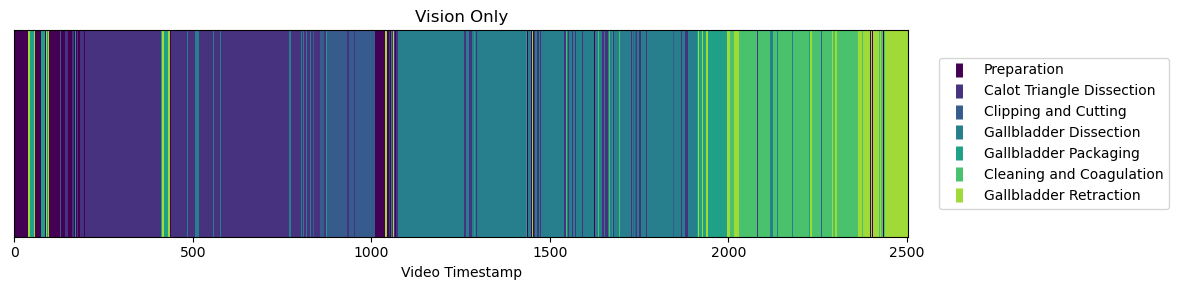

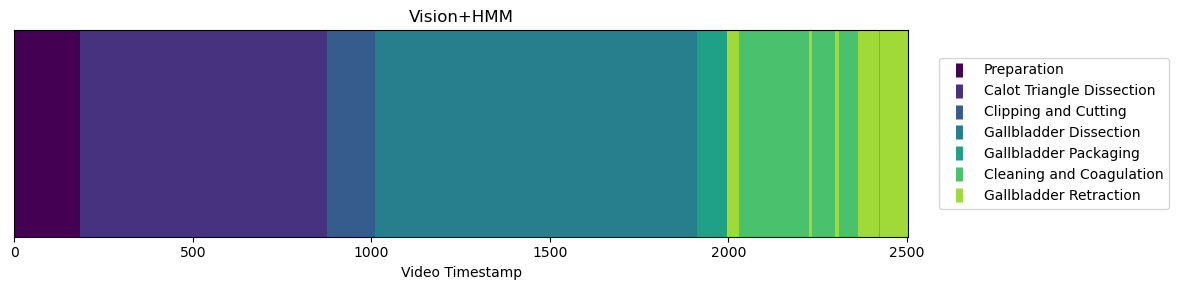

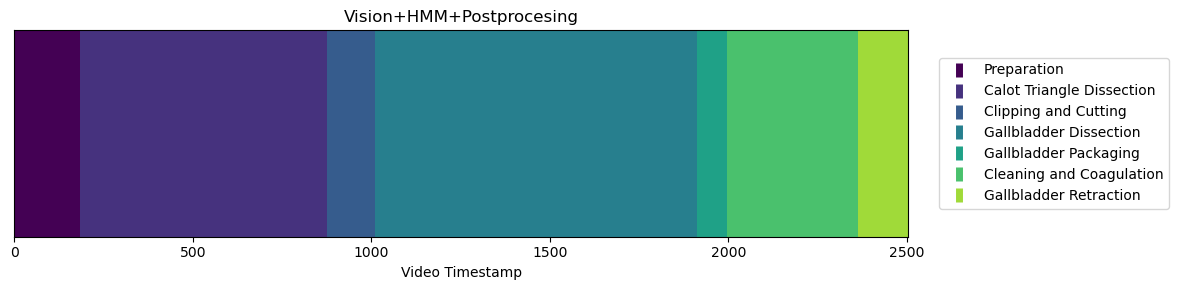

Start decoding vid video78:  ...


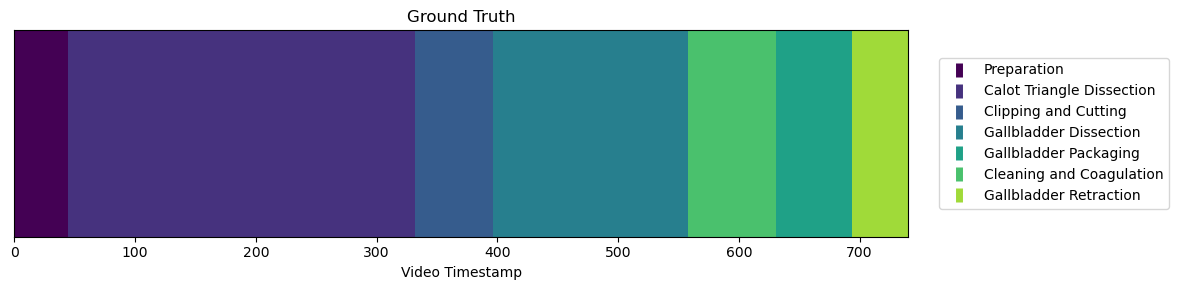

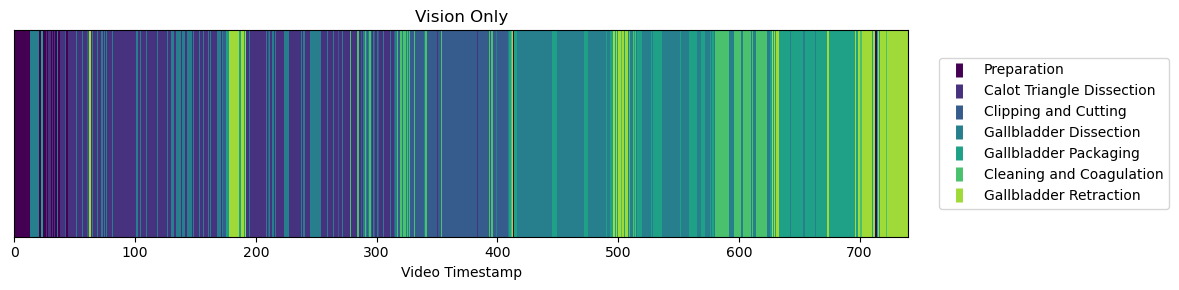

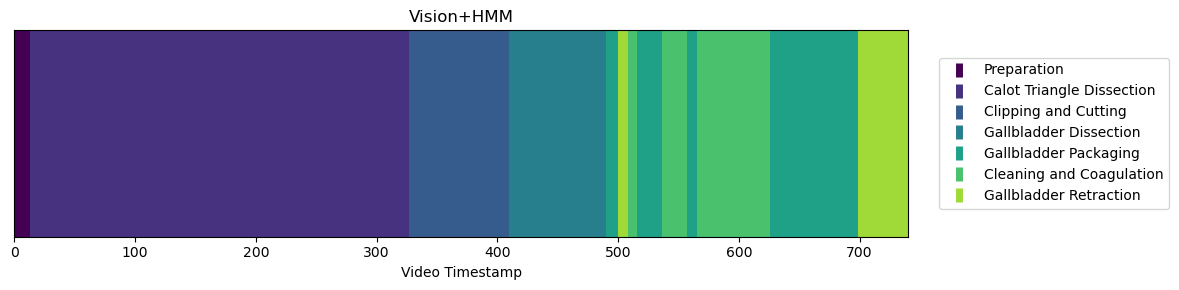

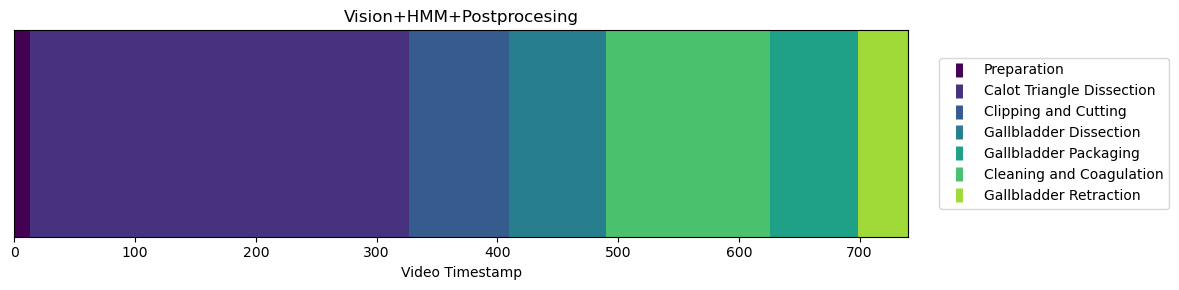

Start decoding vid video79:  ...


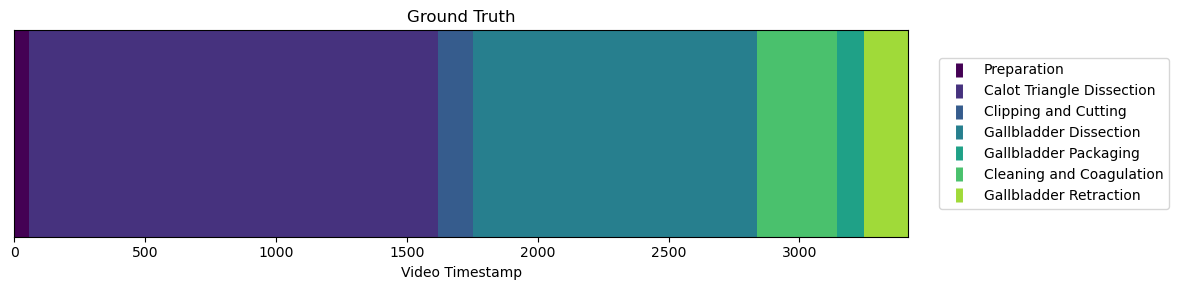

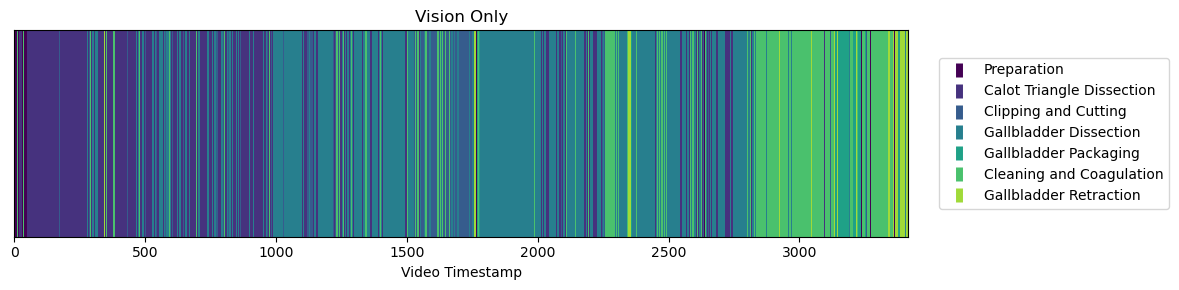

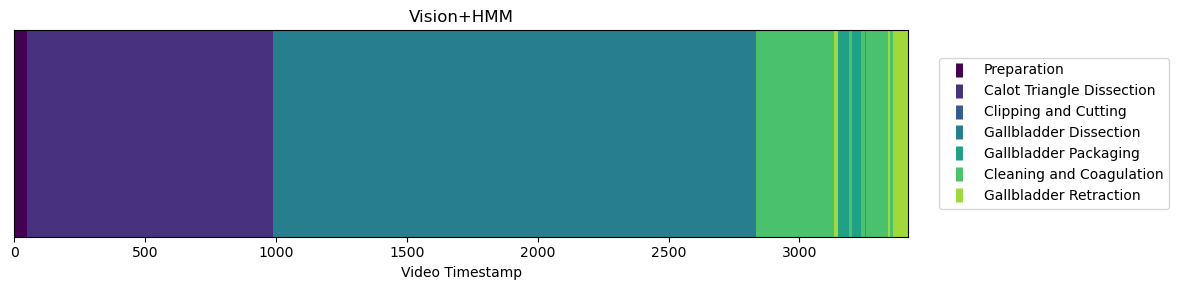

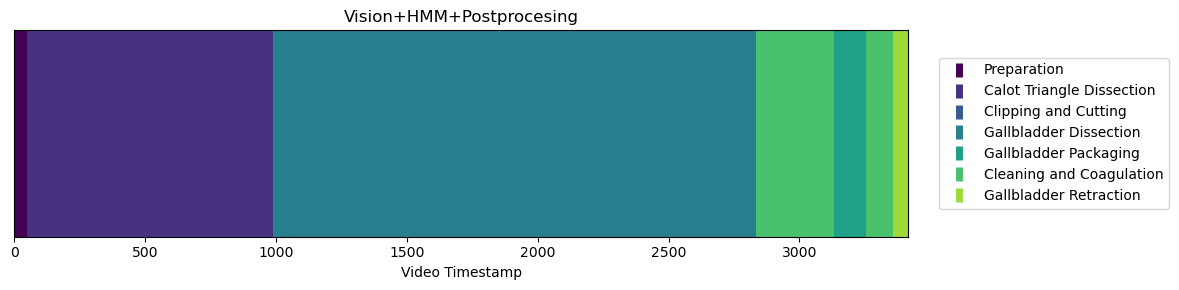

Start decoding vid video80:  ...


c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vkula\anaconda3\lib\site-packages\sklearn\metrics\_classifi

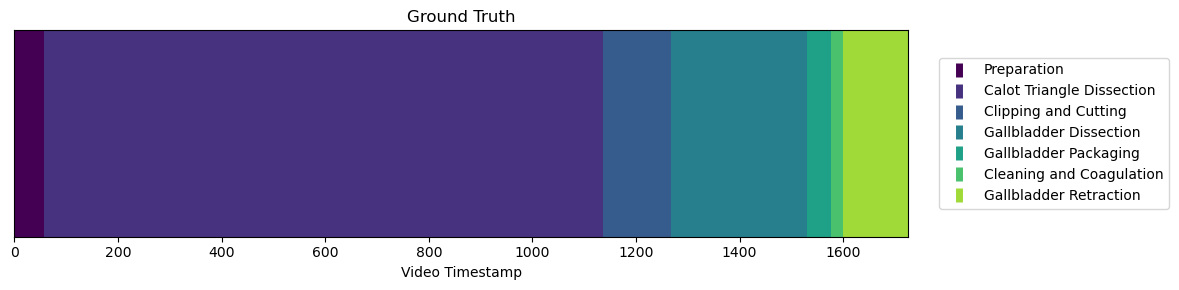

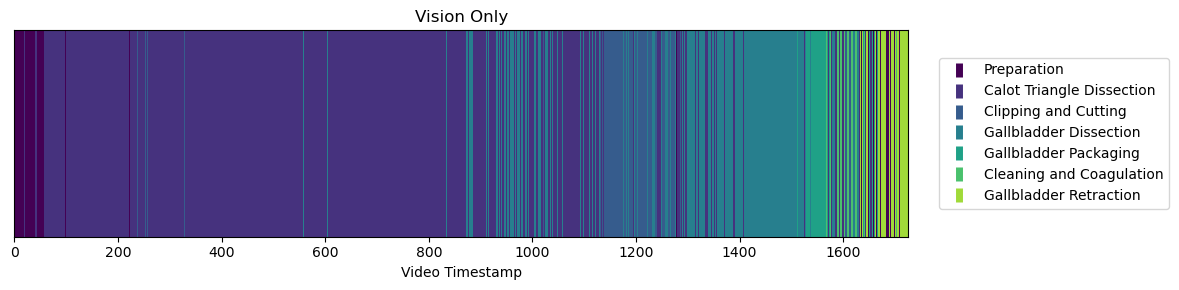

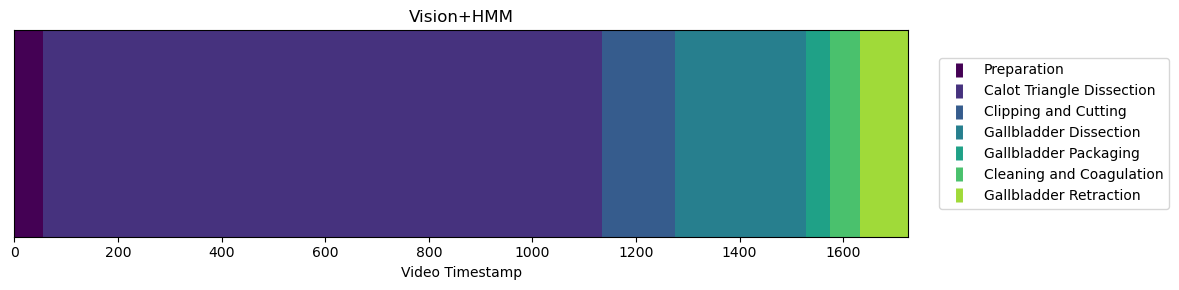

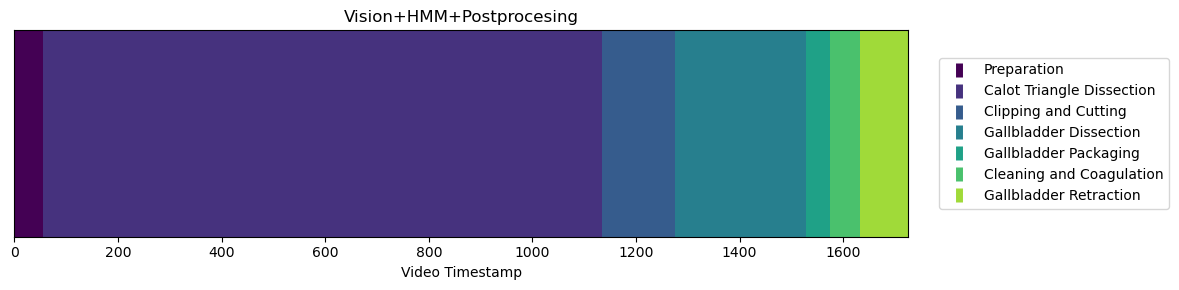

In [15]:
all_vid_prec = []
all_vid_rec = []
all_vid_f1 = []
all_vid_acc = []
all_vid_class_rep = []
all_ground_truth = []
all_pred = []

for video in results_df['video_num'].unique():
    vid_results_df = results_df[results_df['video_num'] == video]
    prec, rec,f1,accuracy, class_rep,gt,pred = single_vid_eval(vid_results_df,hmm_model=hmm_model,ma_length=30,method='hmmfixed')

    all_vid_prec.append(prec)
    all_vid_rec.append(rec)
    all_vid_f1.append(f1)
    all_vid_acc.append(accuracy)
    all_vid_class_rep.append(class_rep)
    all_ground_truth.append(gt)
    all_pred.append(pred)
    

In [16]:
print(f'Precision mean for all vids is: {np.mean(all_vid_prec)} +- {1.96 * np.std(all_vid_prec) / np.sqrt(len(all_vid_prec))}')
print(f'Recall mean for all vids is: {np.mean(all_vid_rec)} +- {1.96 * np.std(all_vid_rec) / np.sqrt(len(all_vid_rec))}')
print(f'F1 Score mean for all vids is: {np.mean(all_vid_f1)} +- {1.96 * np.std(all_vid_f1) / np.sqrt(len(all_vid_f1))}')
print(f'Accuracy mean for all vids is: {np.mean(all_vid_acc)} +- {1.96 * np.std(all_vid_acc) / np.sqrt(len(all_vid_acc))}')

Precision mean for all vids is: 0.8569772256878494 +- 0.037274002102414
Recall mean for all vids is: 0.791488978043368 +- 0.04014231034162699
F1 Score mean for all vids is: 0.7879001979914905 +- 0.043722324241145326
Accuracy mean for all vids is: 0.791488978043368 +- 0.04014231034162699


In [18]:
print(f'Precision mean for all vids is: {np.mean(all_vid_prec)} +- {1.96 * np.std(all_vid_prec) / np.sqrt(len(all_vid_prec))}')
print(f'Recall mean for all vids is: {np.mean(all_vid_rec)} +- {1.96 * np.std(all_vid_rec) / np.sqrt(len(all_vid_rec))}')
print(f'F1 Score mean for all vids is: {np.mean(all_vid_f1)} +- {1.96 * np.std(all_vid_f1) / np.sqrt(len(all_vid_f1))}')
print(f'Accuracy mean for all vids is: {np.mean(all_vid_acc)} +- {1.96 * np.std(all_vid_acc) / np.sqrt(len(all_vid_acc))}')

Precision mean for all vids is: 0.8564291729891087 +- 0.03757789454600819
Recall mean for all vids is: 0.7941464368374469 +- 0.040890450659021915
F1 Score mean for all vids is: 0.789578307567771 +- 0.04431873268273711
Accuracy mean for all vids is: 0.7941464368374469 +- 0.040890450659021915


In [20]:
print(f'Precision mean for all vids is: {np.mean(all_vid_prec)} +- {1.96 * np.std(all_vid_prec) / np.sqrt(len(all_vid_prec))}')
print(f'Recall mean for all vids is: {np.mean(all_vid_rec)} +- {1.96 * np.std(all_vid_rec) / np.sqrt(len(all_vid_rec))}')
print(f'F1 Score mean for all vids is: {np.mean(all_vid_f1)} +- {1.96 * np.std(all_vid_f1) / np.sqrt(len(all_vid_f1))}')
print(f'Accuracy mean for all vids is: {np.mean(all_vid_acc)} +- {1.96 * np.std(all_vid_acc) / np.sqrt(len(all_vid_acc))}')

Precision mean for all vids is: 0.7940388612833102 +- 0.02737297695071037
Recall mean for all vids is: 0.72809030289177 +- 0.042139955086973026
F1 Score mean for all vids is: 0.7179634679360198 +- 0.04378698292089401
Accuracy mean for all vids is: 0.72809030289177 +- 0.042139955086973026


In [16]:
print(f'Precision mean for all vids is: {np.mean(all_vid_prec)} +- {1.96 * np.std(all_vid_prec) / np.sqrt(len(all_vid_prec))}')
print(f'Recall mean for all vids is: {np.mean(all_vid_rec)} +- {1.96 * np.std(all_vid_rec) / np.sqrt(len(all_vid_rec))}')
print(f'F1 Score mean for all vids is: {np.mean(all_vid_f1)} +- {1.96 * np.std(all_vid_f1) / np.sqrt(len(all_vid_f1))}')
print(f'Accuracy mean for all vids is: {np.mean(all_vid_acc)} +- {1.96 * np.std(all_vid_acc) / np.sqrt(len(all_vid_acc))}')

Precision mean for all vids is: 0.9280362629826372 +- 0.024543665268154723
Recall mean for all vids is: 0.9079016629656014 +- 0.02797674164457712
F1 Score mean for all vids is: 0.9062034906616743 +- 0.030176012597139014
Accuracy mean for all vids is: 0.9079016629656014 +- 0.02797674164457712


In [16]:
print(f'Precision mean for all vids is: {np.mean(all_vid_prec)} +- {1.96 * np.std(all_vid_prec) / np.sqrt(len(all_vid_prec))}')
print(f'Recall mean for all vids is: {np.mean(all_vid_rec)} +- {1.96 * np.std(all_vid_rec) / np.sqrt(len(all_vid_rec))}')
print(f'F1 Score mean for all vids is: {np.mean(all_vid_f1)} +- {1.96 * np.std(all_vid_f1) / np.sqrt(len(all_vid_f1))}')
print(f'Accuracy mean for all vids is: {np.mean(all_vid_acc)} +- {1.96 * np.std(all_vid_acc) / np.sqrt(len(all_vid_acc))}')

Precision mean for all vids is: 0.9280362629826372 +- 0.024543665268154723
Recall mean for all vids is: 0.9079016629656014 +- 0.02797674164457712
F1 Score mean for all vids is: 0.9062034906616743 +- 0.030176012597139014
Accuracy mean for all vids is: 0.8851006395798534 +- 0.030777897885281343


In [16]:
print(f'Precision mean for all vids is: {np.mean(all_vid_prec)} +- {1.96 * np.std(all_vid_prec) / np.sqrt(len(all_vid_prec))}')
print(f'Recall mean for all vids is: {np.mean(all_vid_rec)} +- {1.96 * np.std(all_vid_rec) / np.sqrt(len(all_vid_rec))}')
print(f'F1 Score mean for all vids is: {np.mean(all_vid_f1)} +- {1.96 * np.std(all_vid_f1) / np.sqrt(len(all_vid_f1))}')
print(f'Accuracy mean for all vids is: {np.mean(all_vid_acc)} +- {1.96 * np.std(all_vid_acc) / np.sqrt(len(all_vid_acc))}')

Precision mean for all vids is: 0.9280362629826372 +- 0.024543665268154723
Recall mean for all vids is: 0.9079016629656014 +- 0.02797674164457712
F1 Score mean for all vids is: 0.9062034906616743 +- 0.030176012597139014
Accuracy mean for all vids is: 0.8851006395798534 +- 0.030777897885281343


Precision mean for all vids is: 0.9260463001094441 +- 0.022180301639730563
Recall mean for all vids is: 0.8830431923978463 +- 0.03458584825357451
F1 Score mean for all vids is: 0.888471561787872 +- 0.03404337680664133
Accuracy mean for all vids is: 0.8830431923978463 +- 0.03458584825357451

In [ ]:
print(f'Precision mean for all vids is: {np.mean(all_vid_prec)} +- {1.96 * np.std(all_vid_prec) / np.sqrt(len(all_vid_prec))}')
print(f'Recall mean for all vids is: {np.mean(all_vid_rec)} +- {1.96 * np.std(all_vid_rec) / np.sqrt(len(all_vid_rec))}')
print(f'F1 Score mean for all vids is: {np.mean(all_vid_f1)} +- {1.96 * np.std(all_vid_f1) / np.sqrt(len(all_vid_f1))}')
print(f'Accuracy mean for all vids is: {np.mean(all_vid_acc)} +- {1.96 * np.std(all_vid_acc) / np.sqrt(len(all_vid_acc))}')

In [17]:
all_vid_gt = np.concatenate(all_ground_truth)
all_vid_preds = np.concatenate(all_pred)

# get a confusion matrix
cm = confusion_matrix(all_vid_gt, all_vid_preds)

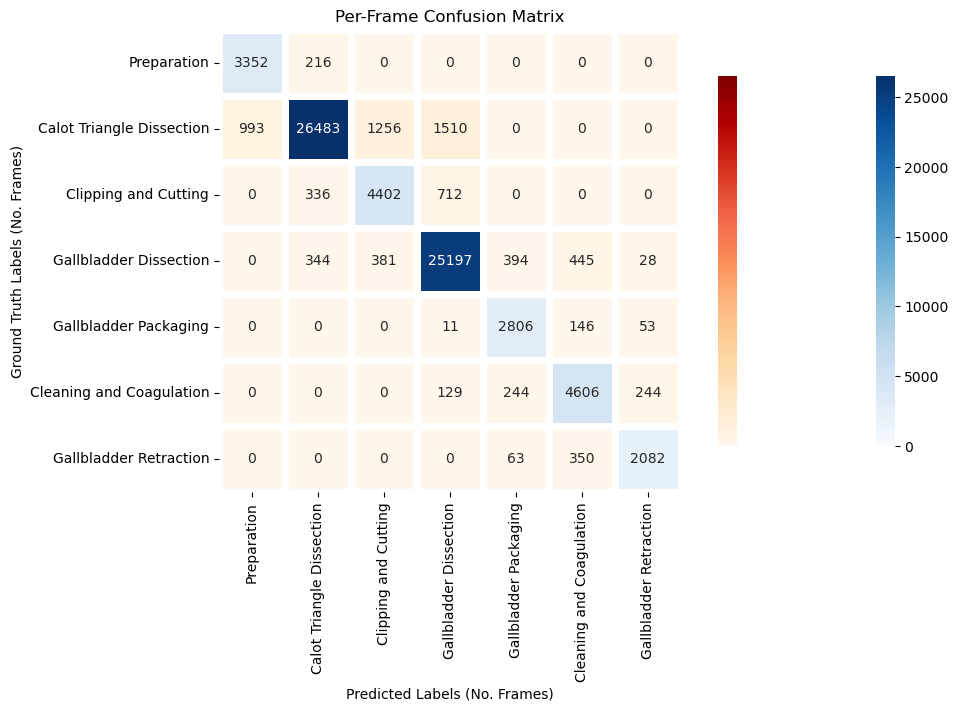

In [21]:
# Confusion matrix for all classes - per frame 
vmin = np.min(cm)
vmax = np.max(cm)
off_diag_mask = np.eye(*cm.shape, dtype=bool)

fig = plt.figure(figsize=(12, 6))
sns.heatmap(
    cm,
    xticklabels=CLASS_LABELS,
    yticklabels=CLASS_LABELS,
    annot=True,
    mask=~off_diag_mask,
    cmap="Blues",
    linewidths=5,
    vmin=vmin,
    vmax=vmax,
    cbar_kws={"shrink": .8},
    fmt="d",
    square=True
)
sns.heatmap(
    cm,
    xticklabels=CLASS_LABELS,
    yticklabels=CLASS_LABELS,
    annot=True,
    mask=off_diag_mask,
    cmap="OrRd",
    linewidths=5,
    vmin=vmin,
    vmax=vmax,
    cbar_kws=dict(ticks=[],shrink=.8),
    fmt="d",
    square=True
)

plt.xlabel("Predicted Labels (No. Frames)")
plt.ylabel("Ground Truth Labels (No. Frames)")
plt.title("Per-Frame Confusion Matrix")
plt.show()

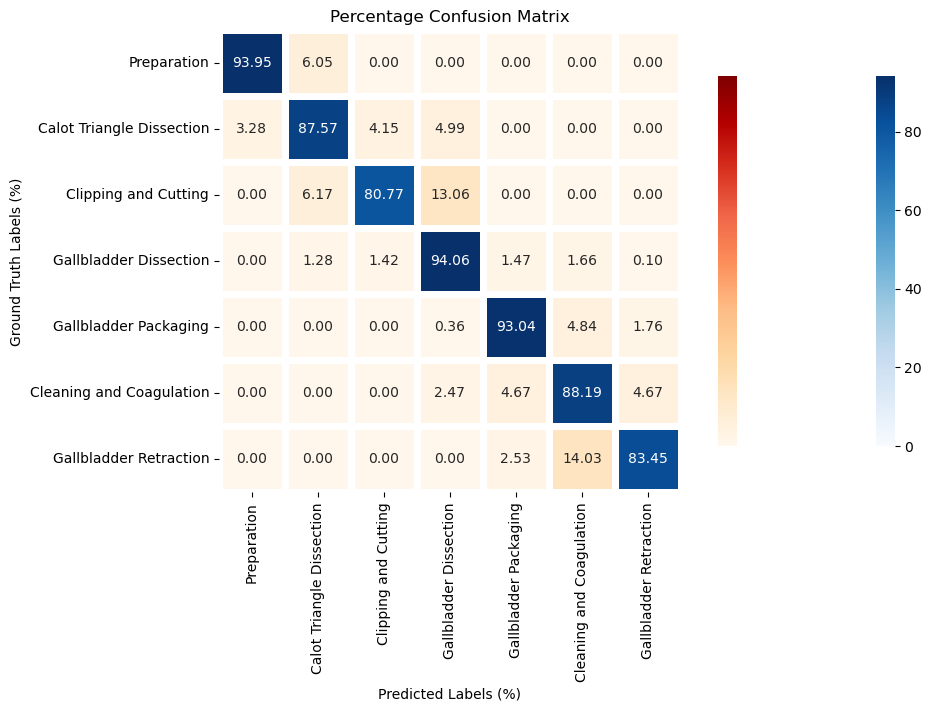

In [22]:
# Confusion matrix for all classes - percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
vmin = np.min(cm_percent)
vmax = np.max(cm_percent)
off_diag_mask = np.eye(*cm_percent.shape, dtype=bool)

fig = plt.figure(figsize=(12, 6))
sns.heatmap(
    cm_percent,
    xticklabels=CLASS_LABELS,
    yticklabels=CLASS_LABELS,
    annot=True,
    mask=~off_diag_mask,
    cmap="Blues",
    linewidths=5,
    vmin=vmin,
    vmax=vmax,
    cbar_kws={"shrink": .8},
    fmt=".2f",
    square=True
)
sns.heatmap(
    cm_percent,
    xticklabels=CLASS_LABELS,
    yticklabels=CLASS_LABELS,
    annot=True,
    mask=off_diag_mask,
    cmap="OrRd",
    linewidths=5,
    vmin=vmin,
    vmax=vmax,
    cbar_kws=dict(ticks=[],shrink=.8),
    fmt=".2f",
    square=True
)

plt.xlabel("Predicted Labels (%)")
plt.ylabel("Ground Truth Labels (%)")
plt.title('Percentage Confusion Matrix')
plt.show()

In [ ]:
# Confusion matrix for all classes - percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
vmin = np.min(cm_percent)
vmax = np.max(cm_percent)
off_diag_mask = np.eye(*cm_percent.shape, dtype=bool)

fig = plt.figure(figsize=(12, 6))
sns.heatmap(
    cm_percent,
    xticklabels=CLASS_LABELS,
    yticklabels=CLASS_LABELS,
    annot=True,
    mask=~off_diag_mask,
    cmap="Blues",
    linewidths=5,
    vmin=vmin,
    vmax=vmax,
    cbar_kws={"shrink": .8},
    fmt=".2f",
    square=True
)
sns.heatmap(
    cm_percent,
    xticklabels=CLASS_LABELS,
    yticklabels=CLASS_LABELS,
    annot=True,
    mask=off_diag_mask,
    cmap="OrRd",
    linewidths=5,
    vmin=vmin,
    vmax=vmax,
    cbar_kws=dict(ticks=[],shrink=.8),
    fmt=".2f",
    square=True
)

plt.xlabel("Predicted Labels (%)")
plt.ylabel("Ground Truth Labels (%)")
plt.title('Percentage Confusion Matrix')
plt.show()

In [ ]:
test_df = results_df[results_df['video_num'] == 'video80']

all_vid_prec = []
all_vid_rec = []
all_vid_f1 = []
all_vid_acc = []
all_vid_class_rep = []
all_ground_truth = []

all_pred = []


for video in test_df['video_num'].unique():
    vid_results_df = results_df[results_df['video_num'] == video]



    
    prec, rec,f1,accuracy, class_rep,gt,pred = single_vid_eval(vid_results_df,hmm_model=hmm_model,ma_length=30,method='hmm')

    all_vid_prec.append(prec)
    all_vid_rec.append(rec)
    all_vid_f1.append(f1)
    all_vid_acc.append(accuracy)
    all_vid_class_rep.append(class_rep)
    all_ground_truth.append(gt)
    all_pred.append(pred)
    
# print(f'Precision mean for all vids is: {np.mean(all_vid_prec)} +- {1.96 * np.std(all_vid_prec) / np.sqrt(len(all_vid_prec))}')
# print(f'Recall mean for all vids is: {np.mean(all_vid_rec)} +- {1.96 * np.std(all_vid_rec) / np.sqrt(len(all_vid_rec))}')
# print(f'F1 Score mean for all vids is: {np.mean(all_vid_f1)} +- {1.96 * np.std(all_vid_f1) / np.sqrt(len(all_vid_f1))}')
# print(f'Accuracy mean for all vids is: {np.mean(all_vid_acc)} +- {1.96 * np.std(all_vid_acc) / np.sqrt(len(all_vid_acc))}')
cnn_probs =  np.array([np.array(xi) for xi in vid_results_df['cnn_output'].to_numpy()])

In [ ]:
def fix_length_preds(pred_array,cnn_probs,thresh=35):
    new_pred_array = pred_array.copy()
    if len(pred_array) >= 3000:
        thresh = 45

    

    lengths,positions,phase_labels = rle(new_pred_array)
    smaller_than_thresh = lengths[1:-1] < thresh
    
    while any(smaller_than_thresh):
        length_to_fix = lengths[1:-1][smaller_than_thresh]
        positions_to_fix = positions[1:-1][smaller_than_thresh]
        phase_labels = phase_labels[1:-1][smaller_than_thresh]
 
        #Find preivous section predictions
        final_positions_start = positions_to_fix - 1
        final_positions_end = positions_to_fix + length_to_fix + 1
        #Check if they are the same
        eq_prev_preds = new_pred_array[final_positions_start] == new_pred_array[final_positions_end]
        for i in range(len(positions_to_fix[eq_prev_preds])):
            new_pred_array[positions_to_fix[eq_prev_preds][i]:positions_to_fix[eq_prev_preds][i] + length_to_fix[eq_prev_preds][i]] = new_pred_array[final_positions_start][eq_prev_preds][i]

        if not any(eq_prev_preds):
            for j in range(len(positions_to_fix[~eq_prev_preds])):
                cnn_comp_probas = (np.vstack(cnn_probs[positions_to_fix[j]:positions_to_fix[j] + length_to_fix[j]]) / np.linalg.norm(np.vstack(cnn_probs[positions_to_fix[j]:positions_to_fix[j] + length_to_fix[j]]))).clip(min=0)
                cnn_sum_sorted = np.argsort(cnn_comp_probas.sum(axis=0))[::-1]
                likeliest_class = new_pred_array[positions_to_fix[j]]
                for phase_class in cnn_sum_sorted:
                    if phase_class == new_pred_array[final_positions_start][~eq_prev_preds][j] or phase_class == new_pred_array[final_positions_end][~eq_prev_preds][j]:
                        likeliest_class = phase_class
                        break
                new_pred_array[positions_to_fix[~eq_prev_preds][j]:positions_to_fix[~eq_prev_preds][j] + length_to_fix[~eq_prev_preds][j]] = likeliest_class
                    
   
        lengths,positions,phase_labels = rle(new_pred_array)
        smaller_than_thresh = lengths[1:-1] < thresh

        show_ribbon_plot(gt,'Ground Truth',classes)
        show_ribbon_plot(pred,'Predicted',classes)
        show_ribbon_plot(new_pred_array,'New Predicted',classes)

        

    return new_pred_array

_ = fix_length_preds(pred,cnn_probs)

In [20]:
print(classification_report(all_vid_gt,all_vid_preds,digits=4,labels=np.unique(all_vid_gt),target_names =CLASS_LABELS))

                           precision    recall  f1-score   support

              Preparation     0.7715    0.9395    0.8472      3568
Calot Triangle Dissection     0.9673    0.8757    0.9192     30242
     Clipping and Cutting     0.7289    0.8077    0.7663      5450
   Gallbladder Dissection     0.9143    0.9406    0.9272     26789
    Gallbladder Packaging     0.8001    0.9304    0.8603      3016
 Cleaning and Coagulation     0.8304    0.8819    0.8553      5223
   Gallbladder Retraction     0.8650    0.8345    0.8494      2495

                 accuracy                         0.8977     76783
                macro avg     0.8396    0.8872    0.8607     76783
             weighted avg     0.9036    0.8977    0.8989     76783



In [ ]:
print(classification_report(all_vid_gt,all_vid_preds,digits=4,labels=np.unique(all_vid_gt),target_names =CLASS_LABELS))

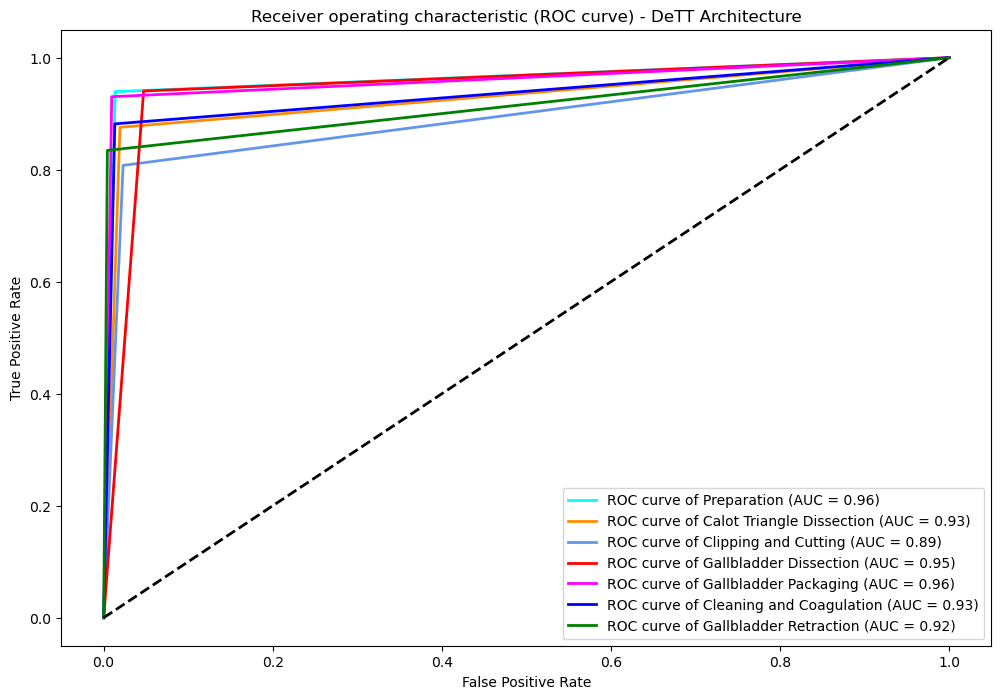

In [26]:
# plot the ROC curve
n_classes = 7
lw = 2

lb = LabelBinarizer()
lb.fit(all_vid_gt)

y_actual = lb.transform(all_vid_gt)
y_pred = lb.transform(all_vid_preds)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(
        y_actual[:, i], y_pred[:, i], drop_intermediate=True)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# font = {"family": "DejaVu Sans", "size": 24}
# plt.rc("font", **font)
# Plot all ROC curves
plt.figure(figsize=(12, 8))
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (AUC = {0:0.2f})" "".format(
#         roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

# plt.plot(
#     fpr["macro"],
#     tpr["macro"],
#     label="macro-average ROC curve (AUC = {0:0.2f})" "".format(
#         roc_auc["macro"]),
#     color="navy",
#     linestyle=":",
#     linewidth=4,
# )

colors = cycle(
    ["aqua", "darkorange", "cornflowerblue", "red", "magenta", "blue", "green"]
)


for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of " + str(CLASS_LABELS[i]) + " (AUC = {1:0.2f})"
        "".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
# plt.xlim([0.0, 1.00])
# plt.ylim([0.0, 1.00])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC curve) - DeTT Architecture")
plt.legend(loc="lower right")
plt.show()